---
<font color='blue' size="8">
GAMMA MIXTURE DENSITY NETWORKS
<font>

---

<font color='black' size="5">
Prediction of galaxy distances using $\gamma$ Mixture Density Networks 

Application to the year 3 Dark Energy Survey data.


<font color='black' size="5">
Luis Cerdán, PhD (lcerdanphd@gmail.com)


*Supervisor*:

* Aurelio Carnero Rosell, Instituto de Astrofísica de Canarias (IAC). E-mail: aurelio.carnero@iac.es 



---
Version date: 8th October 2020.

In this version of the code with respect to the one in file My_MDN_8.ipynb:

* I will be adapting the code My_MDN_TFM.pynb, but will include the analyses of My_MDN_8.ipynb

* I removed the magnitude errors from the model

* I doubled the batch size

https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57

* I set the random seed both for tensorflow and for the initializer inside the Keras model so that the model results are consistent from run to run.




First things first. Let's fix the random seed in tensorflow

In [1]:
from tensorflow.random import set_seed
set_seed(314)

---
# Introduction
---

The determination of galaxy distances in the Universe is a key element in cosmological studies. In general, distances can be accurately measured by measuring the position of known emission lines in the spectrum (spectroscopic redshift). Nevertheless, this process is time-consuming and it limits the total number of distances that can be determined per unit of time. On the other hand, the use of large CCD cameras allows the determination of thousands of galaxy distances simultaneously, amounting for millions of galaxies at the time of the cosmological analysis. Nonetheless, with this method, we pay the price of losing spectral resolution and thus, hindering the determination of precise distances. Several techniques are being use today in photometric galaxy surveys to tackle this problem, and it has been suggested that the use of Mixture Density Networks (MDNs) can bridge this gap, enabling the prediction of galaxy distances from photometric measurements. 

In this Master’s Thesis, the student will adapt, optimize and train an existing MDN using a galaxy sample from the [Dark Energy Survey](http://www.darkenergysurvey.org/) (DES) experiment. Finally, the student will compare the results with those obtained with alternative methods to assess the goodness of the MDN method, and its potential use to future samples of DES.


## Mixture Density Networks (MDN)
---
A Mixture Density Networks (MDNs) is a Multilayer Perceptron (MLP) which last layer is mapped onto the parameters of a mixture of $K$ conditional probability distribution functions (PDF) $\phi_k(y,x)$ given by:

$$
p(y|x)=\sum_{k=1}^K \pi_k(x) \phi_k(y|x)
$$

where $\pi_k(x)$ are the weights or priors for each component of the mixture.

![](https://drive.google.com/uc?export=view&id=1bZOb4hA43eMqrwrXNlfWjD96I3fkXVXu)

In general, MDNs make use of normal distributions $\mathcal{N}(\mu_m,\sigma_m^2)$ as PDFs (i.e., Gaussian Mixture Models), since any distribution can be expressed as a mixture of normal distributions. Nevertheless, this only holds true for random variables $y$ whose PDFs are supported in $\mathbb R$. In our problem at hand, the redshifts are strictly non-negative reals and hence their conditional PDFs must be expressed as the mixture of PDFs which are supported in $\mathbb R^+$.

In this case, we have decided to use gamma distributions:

$$
G_k(y;\alpha_k,\beta_k)=\dfrac{\beta_k^{\alpha_k}}{\Gamma(\alpha_k)}y^{\alpha_k-1}e^{-\beta_ky}
$$

where $\alpha_k$ and $\beta_k$ are the shape and rate parameters of the Gamma distribution, and $\Gamma(·)$ is the gamma function.

The parameters we want to predict for each input $\mathbf{x}^n$ are the mixture weights ($\pi_k$) and the shape parameters ($\alpha_k$, $\beta_k$) for each of the $K$ gamma distributions. Hence, the output layer of the MDN will consist of the $3\times K$ parameters needed to define the mixture of gamma distributions (see figure below). All these parameters are subject to constraints:   

$$
\sum_{k=1}^{K} \pi_k = 1\\
0\leq \pi_k \leq 1\\
\alpha_k, \beta_k > 0
$$  

The first $K$ outputs are mapped to the mixing weights $\pi_k$ by putting them through a softmax transformation, ensuring that they are positive and add to one. The remaining outputs are splitted between the shape parameters $\alpha_k$ and $\beta_k$, and they are mapped by putting them through an offset softplus transformation so that we guarantee that they are positive.

![](https://drive.google.com/uc?export=view&id=1ngqS6mxYvbhEbIhkiNKrcKGIqCOw4aiD)




### Network Architecture

The MDN consists of 5 layers (input, 3 hidden layers, and output). 

>*Input layer*: dimension given by number of features used for the prediction
>
>*Hidden layers*:
* Number of neurons: 128, 64, 32 (ratio 4/2/1)
* Initialization: He-Uniform
* Batch normalization 
* Activation layer: Rectified Linear Unit (ReLU)
>
>*Output layer*:
* Output Dimension: 3 times the number of mixtures $K$
* Activation layer: softplus
* The outputs of the final layer will be mapped onto the mixture coefficients and parameters using the function `get_mixture_coef`.

We will use the `Adam` optimizer with defaul parameters. The network will be constructed using Keras layers.



Function to get the Gamma mixture coefficients from the MLP output layer:

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.math as tfm
 
def get_mixture_coef(output):
    """
    Mapping output layer to mixute components and shape
    parameters of the distribution (pi, alpha, beta)
    """    
    ### split the last layer in 3 'blocks'
    out_pi, out_alpha, out_beta = tf.split(output, 3, 1)
 
    ### softmax transform out_pi
    max_pi = tf.reduce_max(out_pi, 1, keepdims=True)
    out_pi = tf.subtract(out_pi, max_pi)
    out_pi = tf.exp(out_pi)
    normalize_pi = tfm.reciprocal(tf.reduce_sum(out_pi, 1, keepdims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)
 
    ### For out_alpha and out_beta we just add an offset
    alpha_min = 2.0
    out_alpha = tfm.add(out_alpha,alpha_min)   
    
    beta_min = 0.1
    out_beta = tfm.add(out_beta,beta_min)
 
    return out_pi, out_alpha, out_beta
 
# function to get coefficients as numpy arrays
def get_mixture_coef_np(output):
    out_pi, out_alpha, out_beta=get_mixture_coef(output)
    return out_pi.numpy(), out_alpha.numpy(), out_beta.numpy()

Function to define and compile Gamma MDN model:

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
 
# define network architecture with Keras layers
def Gamma_MDN(K,n_neurons,losses, input_shape, RI=True):
  """
  Helper function to define and compile the MDN model.
  We allow the posibility of using the Reliability Index (RI) as metric
  """
  # Mixture parameters
  KMIX = K  # number of mixtures
  NOUT = KMIX * 3  # KMIX times a pi, alpha and beta
 
  # number of neurons of each layer
  n_hidden_1 = n_neurons  # 1st layer
  n_hidden_2 = n_hidden_1/2  # 2nd layer
  n_hidden_3 = n_hidden_2/2  # 3rd layer

  # set initializer properties (to fix random seed)
  initializer = tf.keras.initializers.HeUniform(seed=2718)

  # initialize network and add layers
  model = Sequential()
  # add hidden layer 1
  model.add(Dense(n_hidden_1, input_shape=(input_shape,),
                  kernel_initializer=initializer, 
                  use_bias=False, name='Hidden_1'))
  model.add(BatchNormalization(name='Batch_1'))
  model.add(Activation('relu', name='ReLU_1'))
  # add hidden layer 2
  model.add(Dense(n_hidden_2,
                  kernel_initializer=initializer, 
                  use_bias=False, name='Hidden_2'))
  model.add(BatchNormalization(name='Batch_2'))
  model.add(Activation('relu', name='ReLU_2'))
  # add hidden layer 3
  model.add(Dense(n_hidden_3,
                  kernel_initializer=initializer, 
                  use_bias=False, name='Hidden_3'))
  model.add(BatchNormalization(name='Batch_3'))
  model.add(Activation('relu', name='ReLU_3'))
  # add output layer (the one for the mixture parameters)
  model.add(Dense(NOUT,
                  kernel_initializer=initializer,
                  name='Output'))
  model.add(Activation('softplus', name='Softplus'))
  # compile the model
  if RI:
    model.compile(loss=losses, metrics= RI_metric, optimizer='adam')
  else:
    model.compile(loss=losses, optimizer='adam')
  return model

We can visualize the network:

In [4]:
# summarize the model
X_train=np.ones((100,10))
model = Gamma_MDN(4,128,'', X_train.shape[1],RI=False)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_1 (Dense)            (None, 128)               1280      
                                                                 
 Batch_1 (BatchNormalization  (None, 128)              512       
 )                                                               
                                                                 
 ReLU_1 (Activation)         (None, 128)               0         
                                                                 
 Hidden_2 (Dense)            (None, 64)                8192      
                                                                 
 Batch_2 (BatchNormalization  (None, 64)               256       
 )                                                               
                                                                 
 ReLU_2 (Activation)         (None, 64)                0

## The data set
---

The dataset that we will use to train the $\gamma$-MDN contains, among other variables, photometric information of 143562 galaxies (and some stars) observed by the [Dark Energy Survey](http://www.darkenergysurvey.org/) experiment during the first 3 years of compaing. The features are the fluxes and magnitudes, and their corresponding errors, for the different filters used in the survey (labeled as $g,r,i,z,Y$). In addition, I will include the galaxy shape parameter (SOF_CM_T). The target variable is the spectroscopic redshift $Z$, a magnitude that is proportional to the galaxy distance.


### Load datasets


Link Google Colab with Google Drive:

When prompted, click on the link to get authentication to allow Google to access your Drive. You should see a screen with “Google Cloud SDK wants to access your Google Account”. Give permission and copy the password in the box.

In [5]:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# link to training csv

link_train = 'https://drive.google.com/open?id=1K29s4xnMrLdVoug83Xvh2SUb2UO85eOT' # The shareable link
link_test = 'https://drive.google.com/open?id=11-m0t6QyBfjjoLEu1y83l946DJCyChdX' # The shareable link


# get drive file ID
fluff, id_train = link_train.split('=')
fluff, id_test = link_test.split('=')

# print (id_train) # Verify that you have everything after '='

In [7]:
import pandas as pd
from astropy.table import Table

#import train file from drive
downloaded = drive.CreateFile({'id':id_train}) 
downloaded.GetContentFile('Y3_TRAIN_APRIL2018_NVP_Y4_new.fits')  
dat = Table.read('Y3_TRAIN_APRIL2018_NVP_Y4_new.fits', format='fits')
train_data_set = dat.to_pandas()

#import test file from drive
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('validsample_may2018_2_2_new.fits')  
dat = Table.read('validsample_may2018_2_2_new.fits', format='fits')
test_data_set = dat.to_pandas()

# Datasets are now stored in a Pandas Dataframe


Let's check how the dataset looks like:

In [8]:
train_data_set.head()

,COADD_OBJECT_ID,SOF_CM_T,SOF_CM_T_ERR,RA,DEC,TILENAME,SOURCE,Z,ERR_Z,FLAG_DES,SOF_CM_MAG_CORRECTED_G,SOF_CM_MAG_CORRECTED_R,SOF_CM_MAG_CORRECTED_I,SOF_CM_MAG_CORRECTED_Z,MAG_AUTO_CORRECTED_Y,SOF_CM_MAG_ERR_G,SOF_CM_MAG_ERR_R,SOF_CM_MAG_ERR_I,SOF_CM_MAG_ERR_Z,MAGERR_AUTO_Y
0,61506916,3.764577,0.385326,30.548431,4.650144,b'DES0201+0418',b'SDSS_DR14 ',0.698028,0.000222,4,23.213789,21.370473,20.256999,19.807461,19.785074,0.152481,0.042478,0.032186,0.032562,0.104272
1,61516827,0.359168,0.011379,30.394064,4.380772,b'DES0201+0418',b'SDSS_DR14 ',0.485149,0.000105,4,21.841306,20.177974,19.613286,19.335245,19.178814,0.018396,0.006492,0.006299,0.008005,0.037483
2,61620502,5.195730,0.476184,29.327036,5.301966,b'DES0158+0500',b'SDSS_DR14 ',0.525741,0.000170,4,22.053683,20.250855,19.498483,19.114159,19.225161,0.097941,0.032543,0.029707,0.032866,0.135467
3,61627522,81.941669,0.264586,29.326345,5.048286,b'DES0158+0500',b'SDSS_DR14 ',0.141418,0.000020,4,18.034796,16.907634,16.440987,16.092225,16.203476,0.002249,0.001366,0.001467,0.001617,0.011094
4,61653028,6.302347,0.394694,30.198801,-3.389869,b'DES0200-0333',b'SDSS_DR14 ',0.560591,0.000141,4,22.361394,20.645843,19.866383,19.466826,19.622293,0.051722,0.023183,0.021455,0.021833,0.199585


## Losses function (LF)
---

In this work I will work with Log-likelihood

### Log-likelihood (LL)

The average log-likelihood is defined as:

$$
LF_{LL}=-\dfrac{1}{N}\sum_n^N \ell = -\dfrac{1}{N}\sum_n^N \log \{p(y_n|\mathbf{x}^n)\}=-\dfrac{1}{N}\sum_n^N \log\Biggl\{\sum_{k=1}^K \pi_k(\mathbf{x}^n) G(y_n|\mathbf{x}^n;\alpha_k(\mathbf{x}^n),\beta_k(\mathbf{x}^n))\Biggr\}
$$

where $p(y_n|\mathbf{x}^n)$ is the probability of obtaining the true value $y_n$ given the observations $\mathbf{x}^n$ when sampled from the predicted PDF $p$, which in this case is given by a mixture of $K$ gammas.

Function to compute Log-Likelihood loss function:

In [9]:
import tensorflow as tf
import tensorflow.math as tfm
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import tensorflow_probability as tfp
tfd = tfp.distributions

def gm_ll_loss(y_actual,y_pred):
    # get mixture coefficients    
    out_pi, out_alpha, out_beta = get_mixture_coef(y_pred)
    
    # define mixture distribution
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=out_pi),
        components_distribution=tfd.Gamma(
            concentration=out_alpha,       
            rate=out_beta))
    
    # Evaluate log-probability of y
    log_likelihood = gm.log_prob(tf.transpose(y_actual))     
    return -tf.reduce_mean(log_likelihood, axis=-1)

## Other Metrics
---

### Probability Integral Transform (PIT)

A test to verify whether a set of actual observations are distributed according to a particular distribution is to calculate the Probability Integral Transform (PIT) of each observation. The PIT $p_n$ is the value of the predicted CDF attained at the actual target value $y_n$. For a mixture of gamma distributions this would read:

$$
p_n=\sum_{i=1}^K\pi_i\mathcal{F_G}(y_n; \alpha_i,\beta_i)
$$

The resulting distribution of PIT values should follow a uniform distribution provided that the predicted distributions are perfectly calibrated. This result stems from the fact that any random variable $X$ from a particular distribution $f$ can be transformed into a uniformly distributed random variable $Y$ if the mapping function is given by the CDF of $X$, $F_f$. In mathematical notation, if:

$$
Y=F_f(X)\Rightarrow Y\sim\mathcal{U}(0,1)
$$

This property makes of the PIT a very useful visual tool to verify if the predicted mixture models are accurate or not. Thus, the shape of the PIT histograms reveals whether the predicted distributions are, globally, well calibrated, too broad (*overdispersed*), too narrow (*underdispersed*), biased, or even a mixture of them.

![](https://drive.google.com/uc?export=view&id=1l6B5OhiPMcdQw9tA_eAlN2vsKTUzQJz2)



Function to compute Probability Integral Transform (PIT):

In [10]:
def PIT(y_actual,y_predict):
  # get mixture coefficients  
  out_pi, out_alpha, out_beta = get_mixture_coef(y_predict)   
  # define mixture distribution
  dist = tfd.Gamma(concentration=out_alpha, rate=out_beta)
  # calculate CDF at true redshift
  cdf = dist.cdf(y_actual)
  # take weights pi into account
  M_cdf = tfm.multiply(out_pi,cdf)
  # Return PIT=sum(pi*CDF)
  return tfm.reduce_sum(M_cdf, 1, keepdims=True)

### Reliability Index (RI)

The use of PIT histograms becomes impractical when a large number of them has to be assessed, as may happen if one wanted to evaluate the predictions calibration during the training phase of a neural network. In those cases, it becomes particularly useful to use the reliability index ($RI$), which quantifies how much the PIT histograms depart from uniformity and is calculated as:

$$
RI=\sum_b^B\biggl|\kappa_b-\dfrac{1}{B}\biggr|
$$

\noindent where $\kappa_b$ defines the relative number of observations in the PIT histogram bin $b$, and $B$ is the number of used bins. A perfect prediction would give $RI=0$, the worst prediction (delta distribution or all observations in a single bin) would give $RI=2(B-1)/B$. For $B=20$, $RI\in[0,1.9]$.

Function to compute Reliability Index (RI):

In [11]:
def RI_metric(y_actual,y_predict):
  # calculate PIT values
  F_t=PIT(y_actual,y_predict)
  # get relative number of observations in each bin
  hist = tf.histogram_fixed_width(F_t, [0.0, 1.0], nbins=20, dtype=tf.dtypes.int32, name=None)
  k_t = tfm.divide(hist,tfm.reduce_sum(hist))
  # calculate relative difference from uniformity
  RI = tfm.abs(tfm.subtract(k_t,1/20))
  return tfm.reduce_sum(RI)

---
# Data Inspection and preprocessing
---

## Feature Selection and engineering
---

Select column of interest (redshifts, magnitudes and errors of filters $g,r,i,z$) and remove sources with negative values of the magnitude errors:

In [12]:
feat_sel = ['COADD_OBJECT_ID','Z','SOF_CM_T','SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z', 'MAG_AUTO_CORRECTED_Y', 'ERR_Z', 'SOF_CM_T_ERR','SOF_CM_MAG_ERR_G', 'SOF_CM_MAG_ERR_R', 'SOF_CM_MAG_ERR_I', 'SOF_CM_MAG_ERR_Z', 'MAGERR_AUTO_Y']
df_train = train_data_set[feat_sel]

### Remove galaxies with magnitude errors < 0 and small redshifts (stars)
df_train = df_train[(df_train.Z<2.0) &
                    (df_train.SOF_CM_MAG_ERR_G>0.) &
                    (df_train.SOF_CM_MAG_ERR_R>0.) &
                    (df_train.SOF_CM_MAG_ERR_I>0.) &
                    (df_train.SOF_CM_MAG_ERR_Z>0.) &
                    (df_train.MAG_AUTO_CORRECTED_Y>0.) &
                    (df_train.MAG_AUTO_CORRECTED_Y<40.) &
                    (df_train.SOF_CM_T>0.)]


# let's change the column names for convenience
feat_names = {'COADD_OBJECT_ID': 'id','Z': 'redshift','SOF_CM_T': 'T','SOF_CM_MAG_CORRECTED_G': 'g', 'SOF_CM_MAG_CORRECTED_R': 'r', 'SOF_CM_MAG_CORRECTED_I': 'i', 'SOF_CM_MAG_CORRECTED_Z': 'z', 'MAG_AUTO_CORRECTED_Y': 'Y', 'ERR_Z': 'redshift_err', 'SOF_CM_MAG_ERR_G': 'g_err', 'SOF_CM_MAG_ERR_R': 'r_err', 'SOF_CM_MAG_ERR_I': 'i_err', 'SOF_CM_MAG_ERR_Z': 'z_err', 'MAGERR_AUTO_Y': 'Y_err'}
df_train=df_train.rename(columns=feat_names)


In [13]:
train_data_set.shape

(143562, 20)

Add columns with color differences ($g-r,g-i,\ldots$)

In [14]:
df_train_aug = df_train[['id','redshift','T','g','r','i','z','Y']].copy()
col_names = ['g','r','i','z','Y']
for i in range(len(col_names)-1):
  for j in range(i+1,len(col_names)):
      df_train_aug[col_names[i]+'-'+col_names[j]]= df_train_aug[col_names[i]]-df_train_aug[col_names[j]]

The feature T is highly right skewed (not shown). Correspondingly, we will work with its log10. But we won't change the column name for economy of notation

In [15]:
# take log10 of magnitude errors
df_train_aug['T']=np.log10(df_train_aug['T'])

## Inspecting the data
---

In [16]:
df_train_aug.head()

,id,redshift,T,g,r,i,z,Y,g-r,g-i,g-z,g-Y,r-i,r-z,r-Y,i-z,i-Y,z-Y
0,61506916,0.698028,0.575716,23.213789,21.370473,20.256999,19.807461,19.785074,1.843316,2.956791,3.406328,3.428715,1.113475,1.563012,1.585399,0.449538,0.471924,0.022387
1,61516827,0.485149,-0.444702,21.841306,20.177974,19.613286,19.335245,19.178814,1.663331,2.228019,2.506061,2.662492,0.564688,0.842730,0.999160,0.278042,0.434472,0.156431
2,61620502,0.525741,0.715647,22.053683,20.250855,19.498483,19.114159,19.225161,1.802828,2.555200,2.939524,2.828523,0.752372,1.136695,1.025694,0.384324,0.273322,-0.111001
3,61627522,0.141418,1.913505,18.034796,16.907634,16.440987,16.092225,16.203476,1.127162,1.593809,1.942571,1.831320,0.466647,0.815410,0.704158,0.348763,0.237511,-0.111251
4,61653028,0.560591,0.799502,22.361394,20.645843,19.866383,19.466826,19.622293,1.715551,2.495011,2.894568,2.739101,0.779460,1.179017,1.023550,0.399557,0.244089,-0.155467


**Figure 1: Distribution of each of the magnitudes**

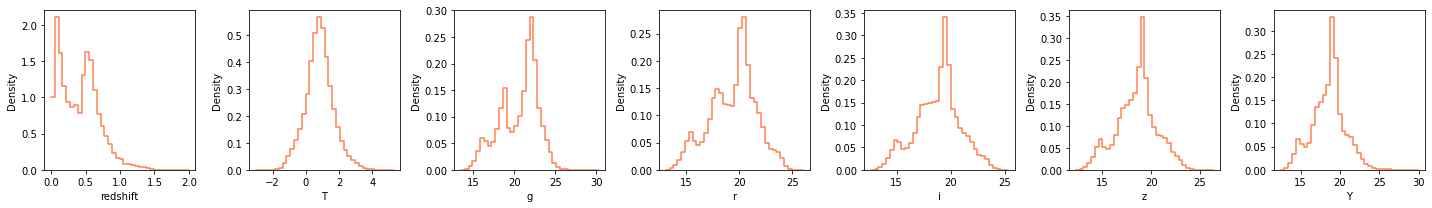

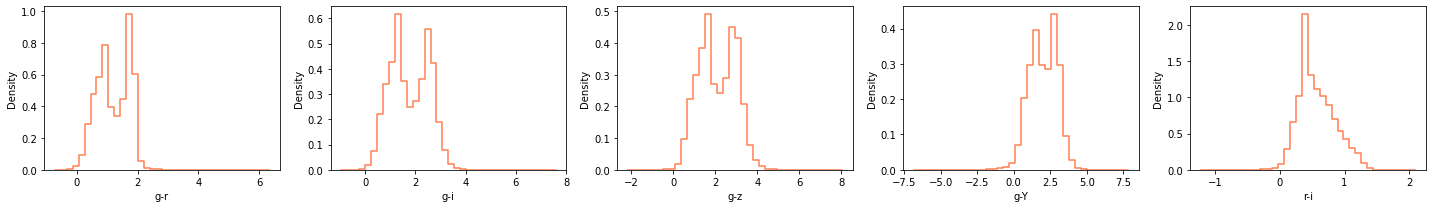

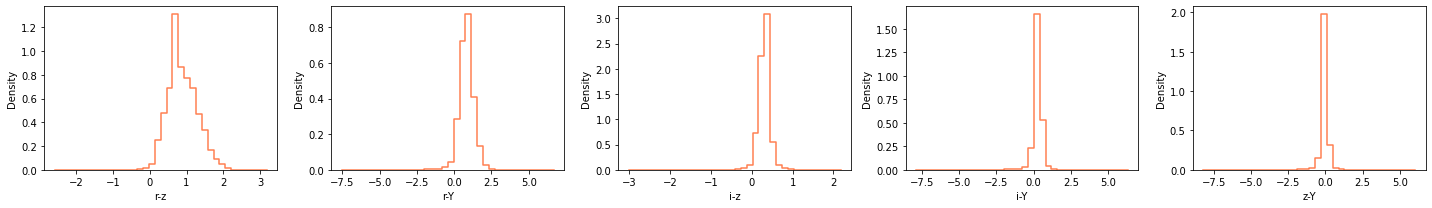

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# function to plot variables
def plot_variables(data,feat_disp):
  fig, axes = plt.subplots(nrows=1, ncols=len(feat_disp), figsize=(20,3))
  for i in range(int(len(feat_disp))):
    # Density Plot and Histogram of all arrival delays
    sns.histplot(data[feat_disp[i]], 
                 element="step",
                 stat="density",
                 bins=int(180/5), 
                 color = 'coral',
                 fill = False, 
                 ax=axes[i])
    axes[i].set_xlabel(feat_disp[i])
    axes[0].set_ylabel('Density')
    #axes[i].set_yscale('log')
  plt.tight_layout()
  plt.show()
  


#features to plot. Magnitudes
feat_disp =['redshift','T','g','r','i','z','Y']
plot_variables(df_train_aug,feat_disp)

#features to plot. Color differences
feat_disp =['g-r','g-i','g-z','g-Y','r-i']
plot_variables(df_train_aug,feat_disp)

#features to plot. Color differences
feat_disp =['r-z','r-Y','i-z','i-Y','z-Y']
plot_variables(df_train_aug,feat_disp)



**Figure 2: Relationship between all the channels and color differences**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
 
# This will prompt for authorization.
drive.mount('/content/drive')
 
# Change path to file directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/gamma MDN photoz DES (Aurelio)')

Mounted at /content/drive


FileNotFoundError: ignored

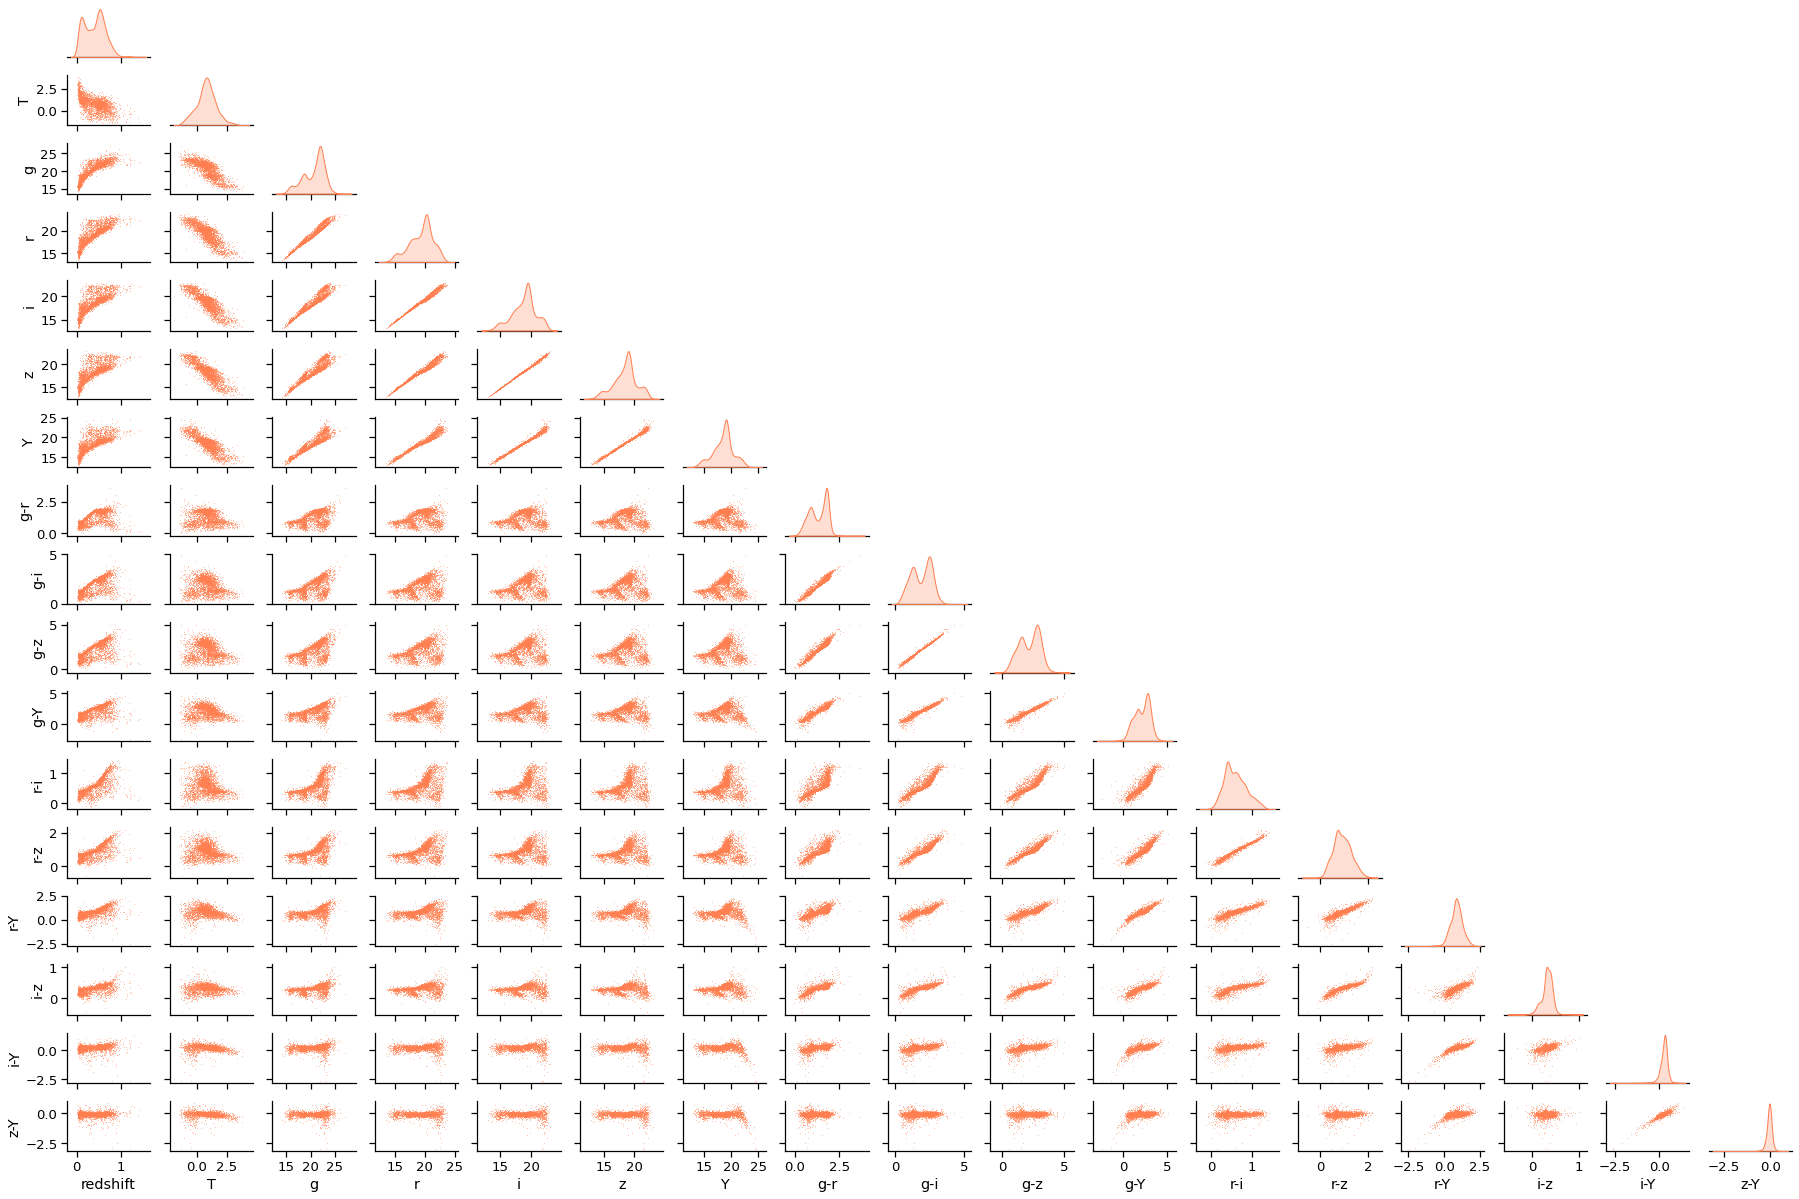

In [18]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1})


### The training features ###
feat_disp = ['redshift','T','g','r','i','z','Y','g-r','g-i','g-z','g-Y','r-i','r-z','r-Y','i-z','i-Y','z-Y']

X = df_train_aug.to_numpy()

df_X = pd.DataFrame(X[0:3000,1:],columns=feat_disp)


pair_colors_scaled = sns.pairplot(df_X, diag_kind="kde", height=1, aspect=1.5, corner=True, 
                                  plot_kws=dict(s=0.5, color = 'coral', edgecolor="coral"),
                                  diag_kws=dict(color='coral'))

#pair_colors_scaled.savefig("features_pair_plot_wT.pdf")

## Principal Component Analysis (PCA)
---

There is a lot of multicollinearity in the covariates. This might give problems when training the MDN. Accordingly, we will have to apply PCA to remove this problem and to reduce the dimensionality.

But before further proceeding, let's remove the redshift (target variable) error, that won't be used, and convert the pandas dataframe to numpy arrays with the features (X) and target (y) variables.

In [30]:
# dataframe with Y channel (w)
df_train_wY = df_train_aug.copy()

# dataframe without Y channel (woY)
df_train_woY = df_train_aug.drop(['Y','g-Y','r-Y','i-Y','z-Y'], axis=1)

### The training features with Y channel ###
feat_train = list(df_train_wY)

Xw = df_train_wY[feat_train[2:]].to_numpy()
yw = df_train_wY.redshift

### The training features with Y channel ###
feat_train = list(df_train_woY)

Xwo = df_train_woY[feat_train[2:]].to_numpy()
ywo = df_train_woY.redshift
Xwo.shape

(141661, 11)

When applying PCA decomposition, it is necesary to standardize the data. In order to mitigate the possible effects of outliers on the standardization, we will use the RobustScaler. Instead of subtracting the mean and deviding by the standard deviation, the RobustScaler subtracts the median and divides by the Inter Quartile Range (IQR). We will implement these two transformations (RobustScaler and PCA) into a Pipeline, as this will prevent problems of data leakage between training, validation and test partitions.

Let's have a look at the PCA decomposition and how much variability is explained by each PC. We will use now the whole dataset, but latter we will take into account the training, validation and test partitions.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Reinitiate the transformer pipeline
steps_w = [('scaler', RobustScaler()), ('pca', PCA())]

steps_wo = [('scaler', RobustScaler()), ('pca', PCA())]

pipeline_w = Pipeline(steps_w)

pipeline_wo = Pipeline(steps_wo)

# fit and transform the whole dataset
X_pca_w=pipeline_w.fit_transform(Xw)
X_pca_wo=pipeline_wo.fit_transform(Xwo)

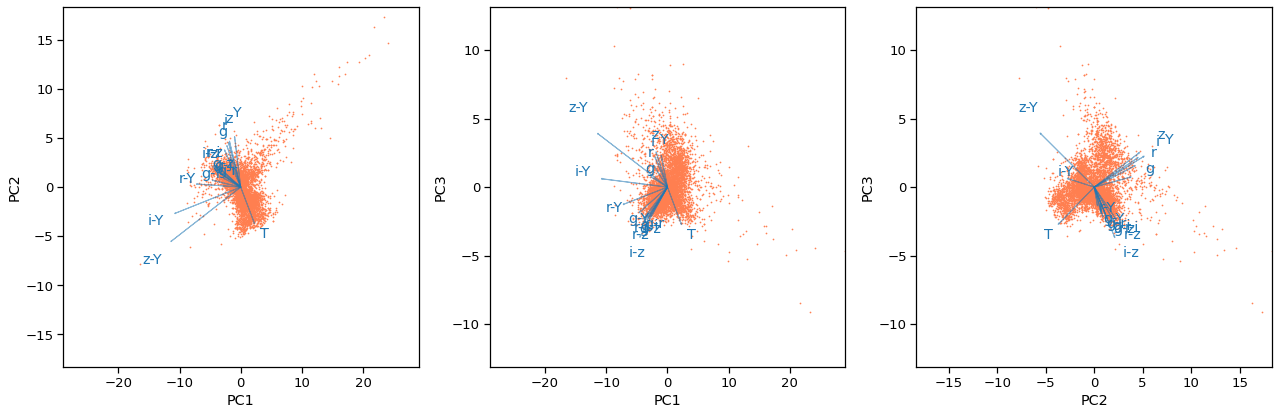

In [21]:
eigenvec = pipeline_w.named_steps.pca.components_
eigenval = pipeline_w.named_steps.pca.explained_variance_ratio_
sample = np.random.randint(0,X_pca_w.shape[0],6000)
x_max = np.max(X_pca_w[sample,0])
y_max = np.max(X_pca_w[sample,1])
z_max = np.max(X_pca_w[sample,2])
x_min = np.min(X_pca_w[sample,0])
y_min = np.min(X_pca_w[sample,1])
z_min = np.min(X_pca_w[sample,2])

fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].scatter(X_pca_w[sample,0],X_pca_w[sample,1], color='coral', s=0.5)
for i in range(X_pca_w.shape[1]):
        ax[0].arrow(0, 0, eigenvec[0,i]*0.7*x_max,eigenvec[1,i]*0.7*y_max,color='tab:blue',alpha=0.5, width=0.01, head_width=0.1)
        ax[0].text(eigenvec[0,i]*x_max, eigenvec[1,i]*y_max,
            list(df_train_wY)[i+2], color='tab:blue')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')


ax[1].scatter(X_pca_w[sample,0],X_pca_w[sample,2], color='coral', s=0.5)
for i in range(X_pca_w.shape[1]):
        ax[1].arrow(0, 0, eigenvec[0,i]*0.7*x_max,eigenvec[2,i]*0.7*z_max,color='tab:blue',alpha=0.5, width=0.01, head_width=0.1)
        ax[1].text(eigenvec[0,i]*x_max, eigenvec[2,i]*z_max,
            list(df_train_wY)[i+2], color='tab:blue')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC3')

ax[2].scatter(X_pca_w[sample,1],X_pca_w[sample,2], color='coral', s=0.5)
for i in range(X_pca_w.shape[1]):
        ax[2].arrow(0, 0, eigenvec[1,i]*0.7*y_max,eigenvec[2,i]*0.7*z_max,color='tab:blue',alpha=0.5, width=0.01, head_width=0.1)
        ax[2].text(eigenvec[1,i]*y_max, eigenvec[2,i]*z_max,
            list(df_train_wY)[i+2], color='tab:blue')
ax[2].set_xlabel('PC2')
ax[2].set_ylabel('PC3')
        
# set axis limits
lim_x=max(np.abs(x_min),x_max)
lim_y=max(np.abs(y_min),y_max)
lim_z=max(np.abs(z_min),z_max)

ax[0].set_xlim(-lim_x,lim_x)
ax[0].set_ylim(-lim_y,lim_y)

ax[1].set_xlim(-lim_x,lim_x)
ax[1].set_ylim(-lim_z,lim_z)

ax[2].set_xlim(-lim_y,lim_y)
ax[2].set_ylim(-lim_z,lim_z)

plt.tight_layout()
plt.show()

In [22]:
var_w = pipeline_w.named_steps.pca.explained_variance_ratio_*100
cum_var_w = pipeline_w.named_steps.pca.explained_variance_ratio_.cumsum()*100

var_wo = pipeline_wo.named_steps.pca.explained_variance_ratio_*100
cum_var_wo = pipeline_wo.named_steps.pca.explained_variance_ratio_.cumsum()*100

print("Percentage of variability explained by the PCs:")
print('            With Y Channel         Without Y Channel')
print("           Var       Cum_var       Var       Cum_var")
for i in range(X_pca_w.shape[1]):
  ind_pc=i+1
  if i <  X_pca_wo.shape[1]:
    print('PC %.0f:    %.5f     %.5f     %.5f     %.5f'   %(ind_pc,var_w[i],cum_var_w[i],var_wo[i],cum_var_wo[i]))
  else:
    print('PC %.0f:    %.5f     %.5f           -            -'   %(ind_pc,var_w[i],cum_var_w[i]))


Percentage of variability explained by the PCs:
            With Y Channel         Without Y Channel
           Var       Cum_var       Var       Cum_var
PC 1:    44.61700     44.61700     56.95160     56.95160
PC 2:    31.18714     75.80414     33.44390     90.39550
PC 3:    18.91621     94.72035     5.19245     95.58794
PC 4:    3.00606     97.72641     2.59277     98.18071
PC 5:    1.29808     99.02450     1.81929     100.00000
PC 6:    0.97550     100.00000     0.00000     100.00000
PC 7:    0.00000     100.00000     0.00000     100.00000
PC 8:    0.00000     100.00000     0.00000     100.00000
PC 9:    0.00000     100.00000     0.00000     100.00000
PC 10:    0.00000     100.00000     0.00000     100.00000
PC 11:    0.00000     100.00000     0.00000     100.00000
PC 12:    0.00000     100.00000           -            -
PC 13:    0.00000     100.00000           -            -
PC 14:    0.00000     100.00000           -            -
PC 15:    0.00000     100.00000           -       

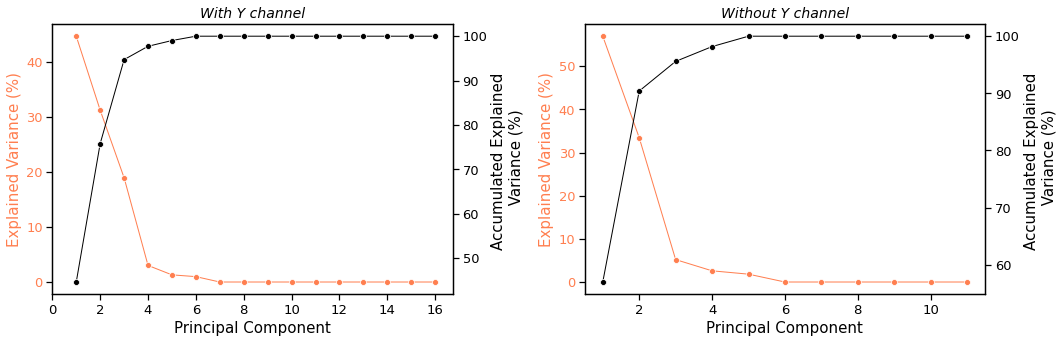

In [23]:
d_w={"x": np.arange(1,X_pca_w.shape[1]+1),"Var": var_w,"Cum_var": cum_var_w}
df_pc_w = pd.DataFrame(data=d_w)

d_wo={"x": np.arange(1,X_pca_wo.shape[1]+1),"Var": var_wo,"Cum_var": cum_var_wo}
df_pc_wo = pd.DataFrame(data=d_wo)

ig, ax = plt.subplots(1,2,figsize=(15,5))

# With Y channel
ax2 = ax[0].twinx() #This allows the common axes (flow rate) to be shared
sns.lineplot(x="x", y="Var",
              marker="o", 
             color = "coral",
             data = df_pc_w, ax=ax[0])
sns.lineplot(x="x", y="Cum_var",
              marker="o", 
             color = 'black',
             data = df_pc_w, ax=ax2)
#ax.set(xlabel='Principal Component', ylabel='Explained Variance (%)')
ax2.set(xlabel='Principal Component', ylabel='Explained Cumulative \n Variance (%)')
ax[0].set_ylabel(ylabel='Explained Variance (%)', color='coral', fontsize=15)  # we already handled the x-label with ax1
ax[0].set_xlabel(xlabel='Principal Component', fontsize=15)  # we already handled the x-label with ax1
ax[0].set_title('With Y channel', style='italic', fontsize=14)
ax[0].tick_params(axis='y', labelcolor='coral', labelsize=13)
ax[0].xaxis.set_ticks(np.arange(0,X_pca_w.shape[1]+2,2))
#tick_labels = np.arange(0,22,2.5)
#ax.set_xticklabels(tick_labels.astype(int))
ax2.set_ylabel(ylabel='Accumulated Explained \n Variance (%)', color='black', fontsize=15)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelsize=13)

#Without Y channel
ax4 = ax[1].twinx() #This allows the common axes (flow rate) to be shared
sns.lineplot(x="x", y="Var",
              marker="o", 
             color = "coral",
             data = df_pc_wo, ax=ax[1])
sns.lineplot(x="x", y="Cum_var",
              marker="o", 
             color = 'black',
             data = df_pc_wo, ax=ax4)
#ax.set(xlabel='Principal Component', ylabel='Explained Variance (%)')
ax4.set(xlabel='Principal Component', ylabel='Explained Cumulative \n Variance (%)')
ax[1].set_ylabel(ylabel='Explained Variance (%)', color='coral', fontsize=15)  # we already handled the x-label with ax1
ax[1].set_xlabel(xlabel='Principal Component', fontsize=15)  # we already handled the x-label with ax1
ax[1].set_title('Without Y channel', style='italic', fontsize=14)
ax[1].tick_params(axis='y', labelcolor='coral', labelsize=13)
#ax[1].xaxis.set_ticks(np.arange(0,X_pca_wo.shape[1]+2,2))
#tick_labels = np.arange(0,22,2.5)
#ax.set_xticklabels(tick_labels.astype(int))
ax4.set_ylabel(ylabel='Accumulated Explained \n Variance (%)', color='black', fontsize=15)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelsize=13)

plt.tight_layout()
#plt.savefig("PC_variability_wT.pdf")
plt.show()

It seems that with 13 PCs we can already explain a 99.99996% of the variability. This would be a considerable reduction in the dimensionality of the problem. In any case, I will be using all of them. 

**Figure 3: First 4 PCs (they are now mostly uncorrelated)**

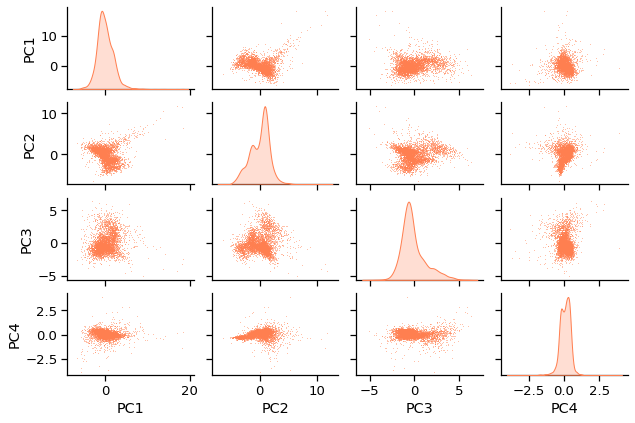

In [24]:
pair_colors_scaled = sns.pairplot(pd.DataFrame(X_pca_w[1:5000,0:4],columns=['PC1','PC2','PC3','PC4']), diag_kind="kde", height=1.5, aspect=1.5, corner=False, 
                                  plot_kws=dict(s=0.5, color = 'coral', edgecolor="coral"),
                                  diag_kws=dict(color='coral'))

#pair_colors_scaled.savefig("PCs_correlation_wT.pdf")

---
# Training the Gamma MDNs
---

I will train two MDNs, one with the Y channle, and one withough. Both models will be assumed multimodal with K = 7. 

* Both models will be optimized to minimize log-likelihood

* To train the network, I will use all PCs, so that I don't loss information.

* I will use early stopping to determine the optimal number of epochs to train the MDNs. To choose the optimal number of epochs, I will use K-fold cross-validation

In [25]:
# remove column with redshift error (let Y changel)
#df_train_wY = df_train_aug.drop(['redshift_err'], axis=1)
df_train_wY = df_train_aug.copy()

# dataframe without Y channel (woY)
#df_train_woY = df_train_aug.drop(['redshift_err','Y','Y_err','g-Y','g-Y_err','r-Y','r-Y_err','i-Y','i-Y_err','z-Y','z-Y_err'], axis=1)
df_train_woY = df_train_aug.drop(['Y','g-Y','r-Y','i-Y','z-Y'], axis=1)

### The training features with Y channel ###
feat_train = list(df_train_wY)

Xw = df_train_wY[feat_train[2:]].to_numpy()
yw = df_train_wY.redshift

### The training features with Y channel ###
feat_train = list(df_train_woY)

Xwo = df_train_woY[feat_train[2:]].to_numpy()
ywo = df_train_woY.redshift

In [26]:
Xw.shape

(141661, 16)

In [27]:
# Reinitiate the transformer pipeline
steps_w = [('scaler', RobustScaler()), ('pca', PCA())]

steps_wo = [('scaler', RobustScaler()), ('pca', PCA())]

pipeline_w = Pipeline(steps_w)

pipeline_wo = Pipeline(steps_wo)

# parameters to initiate and train the gamma-MDN

# number of mixtures
K= 5
# number of neurons for first hidden layer
n_hidden_1=128
# batch_size
batch_size = 256*2
# number of epochs
n_epoch=900 # 400 is more than enough
# number of K folds
n_folds=3
# validation frequency
val_freq=1

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# define training and test partitions
X_training_w, Xtest_w, Y_training_w, Ytest_w = train_test_split(Xw, yw, test_size=15/100, shuffle=True, random_state=1)

# define training and test partitions
X_training_wo, Xtest_wo, Y_training_wo, Ytest_wo = train_test_split(Xwo, ywo, test_size=15/100, shuffle=True, random_state=1)

## Model with Y channel
---

In [35]:
checkpoint_path = "/content/drive/MyDrive/test_in_original_withY_model_callback.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)


# Define the K-fold Cross Validator
kfold_w = KFold(n_splits=n_folds, shuffle=True, random_state=0)

# K-fold Cross Validation model evaluation
fold_no = 1
isFirst = True
for train, val in kfold_w.split(X_training_w, Y_training_w):
 
   # fit and transform the training partition
  X_train=pipeline_w.fit_transform(X_training_w[train])
  Y_train=Y_training_w[train, np.newaxis]
  # transform validation partition
  X_val=pipeline_w.transform(X_training_w[val])
  Y_val=Y_training_w[val, np.newaxis]

  # define and compile model  
  model_w_cv = Gamma_MDN(K,n_hidden_1,gm_ll_loss, X_train.shape[1], True) 

  # Generate a print
  print('------------------------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} out of {n_folds}')
  # Increase fold number
  fold_no = fold_no + 1

  # fit model to data
  with tf.device('/device:GPU:0'):
    history_w_cv=model_w_cv.fit(X_train, Y_train, 
                      validation_data=(X_val,Y_val),# for first validation partition
                      epochs=n_epoch,
                      batch_size = batch_size,
                      verbose=1,
                      validation_freq=val_freq,
                      callbacks=[cp_callback])

  # evaluate and store performance
  if isFirst:
    isFirst = False
    cv_train_loss_w_cv = history_w_cv.history['loss']
    cv_val_loss_w_cv = history_w_cv.history['val_loss']
    cv_train_RI_w_cv = history_w_cv.history['RI_metric']
    cv_val_RI_w_cv = history_w_cv.history['val_RI_metric']
  else: 

    cv_train_loss_w_cv = np.vstack((cv_train_loss_w_cv,history_w_cv.history['loss']))
    cv_val_loss_w_cv = np.vstack((cv_val_loss_w_cv,history_w_cv.history['val_loss']))
    cv_train_RI_w_cv = np.vstack((cv_train_RI_w_cv,history_w_cv.history['RI_metric']))
    cv_val_RI_w_cv = np.vstack((cv_val_RI_w_cv,history_w_cv.history['val_RI_metric']))
    

<ipython-input-35-23725ade5bf2>:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_train=Y_training_w[train, np.newaxis]
<ipython-input-35-23725ade5bf2>:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_val=Y_training_w[val, np.newaxis]


------------------------------------------------------------------------------------------
Training for fold 1 out of 3
Epoch 1/900
157/157 [==============================] - 4s 10ms/step - loss: 0.4704 - RI_metric: 1.0020 - val_loss: -0.0634 - val_RI_metric: 1.0538
Epoch 2/900
157/157 [==============================] - 1s 8ms/step - loss: -0.4070 - RI_metric: 0.8024 - val_loss: -0.5641 - val_RI_metric: 0.8613
Epoch 3/900
157/157 [==============================] - 1s 8ms/step - loss: -0.6422 - RI_metric: 0.8939 - val_loss: -0.7462 - val_RI_metric: 0.8970
Epoch 4/900
157/157 [==============================] - 1s 8ms/step - loss: -0.8016 - RI_metric: 0.9262 - val_loss: -0.8706 - val_RI_metric: 0.9329
Epoch 5/900
157/157 [==============================] - 1s 8ms/step - loss: -0.9214 - RI_metric: 0.9380 - val_loss: -0.9615 - val_RI_metric: 0.9615
Epoch 6/900
157/157 [==============================] - 2s 11ms/step - loss: -1.0162 - RI_metric: 0.9421 - val_loss: -1.0519 - val_RI_metric: 0.94

InvalidArgumentError: ignored

## Model without Y channel
---

In [33]:
checkpoint_path = "/content/drive/MyDrive/test_in_original_noY_model_callback.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

# Define the K-fold Cross Validator
kfold_wo = KFold(n_splits=n_folds, shuffle=True, random_state=0)

# K-fold Cross Validation model evaluation
fold_no = 1
isFirst = True
for train, val in kfold_wo.split(X_training_wo, Y_training_wo):
 
   # fit and transform the training partition
  X_train=pipeline_wo.fit_transform(X_training_wo[train])
  Y_train=Y_training_wo[train, np.newaxis]
  # transform validation partition
  X_val=pipeline_wo.transform(X_training_wo[val])
  Y_val=Y_training_wo[val, np.newaxis]

  # define and compile model  
  model_wo_cv = Gamma_MDN(K,n_hidden_1,gm_ll_loss, X_train.shape[1], True) 

  # Generate a print
  print('------------------------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} out of {n_folds}')
  # Increase fold number
  fold_no = fold_no + 1

  # fit model to data
  with tf.device('/device:GPU:0'):
    history_wo_cv=model_wo_cv.fit(X_train, Y_train, 
                      validation_data=(X_val,Y_val),# for first validation partition
                      epochs=n_epoch,
                      batch_size = batch_size,
                      verbose=1,
                      validation_freq=val_freq,
                      callbacks=[cp_callback])

  # evaluate and store performance
  if isFirst:
    isFirst = False
    cv_train_loss_wo_cv = history_wo_cv.history['loss']
    cv_val_loss_wo_cv = history_wo_cv.history['val_loss']
    cv_train_RI_wo_cv = history_wo_cv.history['RI_metric']
    cv_val_RI_wo_cv = history_wo_cv.history['val_RI_metric']
  else: 

    cv_train_loss_wo_cv = np.vstack((cv_train_loss_wo_cv,history_wo_cv.history['loss']))
    cv_val_loss_wo_cv = np.vstack((cv_val_loss_wo_cv,history_wo_cv.history['val_loss']))
    cv_train_RI_wo_cv = np.vstack((cv_train_RI_wo_cv,history_wo_cv.history['RI_metric']))
    cv_val_RI_wo_cv = np.vstack((cv_val_RI_wo_cv,history_wo_cv.history['val_RI_metric']))
    

<ipython-input-33-e6ee34442d2c>:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_train=Y_training_wo[train, np.newaxis]
<ipython-input-33-e6ee34442d2c>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_val=Y_training_wo[val, np.newaxis]


------------------------------------------------------------------------------------------
Training for fold 1 out of 3
Epoch 1/900
157/157 [==============================] - 4s 10ms/step - loss: 0.3104 - RI_metric: 1.0145 - val_loss: -0.0867 - val_RI_metric: 0.9924
Epoch 2/900
157/157 [==============================] - 1s 9ms/step - loss: -0.4558 - RI_metric: 0.8419 - val_loss: -0.6031 - val_RI_metric: 0.8727
Epoch 3/900
157/157 [==============================] - 2s 10ms/step - loss: -0.6832 - RI_metric: 0.9131 - val_loss: -0.7745 - val_RI_metric: 0.9095
Epoch 4/900
157/157 [==============================] - 1s 8ms/step - loss: -0.8170 - RI_metric: 0.9458 - val_loss: -0.8813 - val_RI_metric: 0.9409
Epoch 5/900
157/157 [==============================] - 1s 7ms/step - loss: -0.9124 - RI_metric: 0.9569 - val_loss: -0.9610 - val_RI_metric: 0.9466
Epoch 6/900
157/157 [==============================] - 1s 7ms/step - loss: -0.9949 - RI_metric: 0.9572 - val_loss: -1.0358 - val_RI_metric: 0.96

<ipython-input-33-e6ee34442d2c>:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_train=Y_training_wo[train, np.newaxis]
<ipython-input-33-e6ee34442d2c>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_val=Y_training_wo[val, np.newaxis]


------------------------------------------------------------------------------------------
Training for fold 2 out of 3
Epoch 1/900
157/157 [==============================] - 4s 12ms/step - loss: 0.3548 - RI_metric: 1.0679 - val_loss: 0.1111 - val_RI_metric: 1.1759
Epoch 2/900
157/157 [==============================] - 1s 8ms/step - loss: -0.3982 - RI_metric: 0.8020 - val_loss: -0.4617 - val_RI_metric: 0.8866
Epoch 3/900
157/157 [==============================] - 1s 8ms/step - loss: -0.6314 - RI_metric: 0.8906 - val_loss: -0.7161 - val_RI_metric: 0.9008
Epoch 4/900
157/157 [==============================] - 1s 8ms/step - loss: -0.7854 - RI_metric: 0.9344 - val_loss: -0.8462 - val_RI_metric: 0.9439
Epoch 5/900
157/157 [==============================] - 1s 8ms/step - loss: -0.8935 - RI_metric: 0.9540 - val_loss: -0.9472 - val_RI_metric: 0.9565
Epoch 6/900
157/157 [==============================] - 1s 8ms/step - loss: -0.9781 - RI_metric: 0.9560 - val_loss: -1.0286 - val_RI_metric: 0.9326

<ipython-input-33-e6ee34442d2c>:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_train=Y_training_wo[train, np.newaxis]
<ipython-input-33-e6ee34442d2c>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_val=Y_training_wo[val, np.newaxis]


------------------------------------------------------------------------------------------
Training for fold 3 out of 3
Epoch 1/900
157/157 [==============================] - 4s 10ms/step - loss: 0.3119 - RI_metric: 0.9957 - val_loss: -0.0849 - val_RI_metric: 1.0261
Epoch 2/900
157/157 [==============================] - 1s 8ms/step - loss: -0.4498 - RI_metric: 0.8635 - val_loss: -0.6026 - val_RI_metric: 0.8890
Epoch 3/900
157/157 [==============================] - 1s 8ms/step - loss: -0.6740 - RI_metric: 0.9242 - val_loss: -0.7852 - val_RI_metric: 0.9166
Epoch 4/900
157/157 [==============================] - 1s 9ms/step - loss: -0.8142 - RI_metric: 0.9572 - val_loss: -0.8802 - val_RI_metric: 0.9472
Epoch 5/900
157/157 [==============================] - 1s 8ms/step - loss: -0.9202 - RI_metric: 0.9712 - val_loss: -0.9625 - val_RI_metric: 0.9778
Epoch 6/900
157/157 [==============================] - 1s 8ms/step - loss: -1.0084 - RI_metric: 0.9628 - val_loss: -1.0433 - val_RI_metric: 0.945

### Training and validation losses



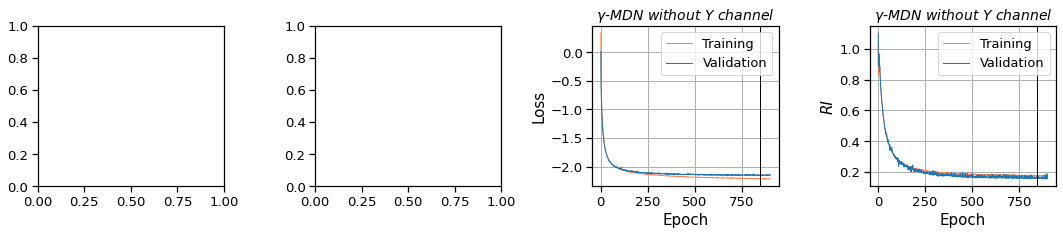

In [38]:
import matplotlib.pyplot as plt

# epochs arrays
epochs_train = history_wo_cv.epoch+np.ones(len(history_wo_cv.epoch))
epochs_val = history_wo_cv.epoch+val_freq*np.ones(len(history_wo_cv.epoch))

## to avoid nans, we use nanmean and nanstd
# losses arrays with Y channel
#mean_train_loss_w_cv=np.nanmean(cv_train_loss_w_cv[1:,:],axis=0)
#mean_val_loss_w_cv=np.nanmean(cv_val_loss_w_cv[1:,:],axis=0)
#mean_train_RI_w_cv=np.nanmean(cv_train_RI_w_cv[1:,:],axis=0)
#mean_val_RI_w_cv=np.nanmean(cv_val_RI_w_cv[1:,:],axis=0)


# losses arrays for log-likelihood. K=5
mean_train_loss_wo_cv=np.nanmean(cv_train_loss_wo_cv[1:,:],axis=0)
mean_val_loss_wo_cv=np.nanmean(cv_val_loss_wo_cv[1:,:],axis=0)
mean_train_RI_wo_cv=np.nanmean(cv_train_RI_wo_cv[1:,:],axis=0)
mean_val_RI_wo_cv=np.nanmean(cv_val_RI_wo_cv[1:,:],axis=0)

# optimal epoch
#epoch_min_w_cv=np.argmin(mean_val_loss_w_cv)+1
#epoch_min_RI_w_cv=np.argmin(mean_val_RI_w_cv)+1
epoch_min_wo_cv=np.argmin(mean_val_loss_wo_cv)+1
epoch_min_wo_cv_wo=np.argmin(mean_val_RI_wo_cv)+1

# Plot training & validation loss values
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3.5))

# plot for crps
# losses
color_1 = "coral"
color_2 = "tab:blue"
#ax[0].plot(epochs_train,mean_train_loss_w_cv,c=color_1)
#ax[0].plot(epochs_val,mean_val_loss_w_cv,c=color_2)
#ax[0].axvline(x=epoch_min_w_cv, color='black', alpha=1)
#ax[0].set_ylim(np.min(mean_train_loss_w_cv),mean_val_loss_w_cv[0])
#ax[0].set_title('$\gamma$-MDN with Y channel', style='italic', fontsize=14)
#ax[0].set_ylabel('Loss', fontsize=15)
#ax[0].set_xlabel('Epoch', fontsize=15)
#ax[0].legend(['Training', 'Validation'], loc='upper right', fontsize=13)
#ax[0].grid()

# RI
#ax[1].plot(epochs_train,mean_train_RI_w_cv,c=color_1)
#ax[1].plot(epochs_val,mean_val_RI_w_cv,c=color_2)
#ax[1].axvline(x=epoch_min_RI_w_cv, color='black', alpha=1)
#ax[1].set_ylim(np.min(mean_val_RI_w_cv),mean_val_RI_w_cv[0])
#ax[1].set_yscale('log')
#ax[1].set_title('$\gamma$-MDN with Y channel', style='italic', fontsize=14)
#ax[1].set_ylabel('RI', style='italic', fontsize=15)
#ax[1].set_xlabel('Epoch', fontsize=15)
#ax[1].legend(['Training', 'Validation'], loc='upper right', fontsize=13)
#ax[1].grid()

# plot for LL
ax[2].plot(epochs_train,mean_train_loss_wo_cv,c=color_1)
ax[2].plot(epochs_val,mean_val_loss_wo_cv,c=color_2)
ax[2].axvline(x=epoch_min_wo_cv, color='black', alpha=1)

ax[2].set_title('$\gamma$-MDN without Y channel', style='italic', fontsize=14)
ax[2].set_ylabel('Loss', fontsize=15)
ax[2].set_xlabel('Epoch', fontsize=15)
ax[2].legend(['Training', 'Validation'], loc='upper right', fontsize=13)
ax[2].grid()

# RI
ax[3].plot(epochs_train,mean_train_RI_wo_cv,c=color_1)
ax[3].plot(epochs_val,mean_val_RI_wo_cv,c=color_2)
ax[3].axvline(x=epoch_min_wo_cv, color='black', alpha=1)

ax[3].set_title('$\gamma$-MDN without Y channel', style='italic', fontsize=14)
ax[3].set_ylabel('RI', style='italic', fontsize=15)
ax[3].set_xlabel('Epoch', fontsize=15)
ax[3].legend(['Training', 'Validation'], loc='upper right', fontsize=13)
ax[3].grid()

hight = 0.90
#fig.text(0.01, hight, "a)", horizontalalignment='left', verticalalignment='center', fontsize=15)
#fig.text(0.265, hight, "b)", horizontalalignment='left', verticalalignment='center', fontsize=15)
#fig.text(0.505, hight, "c)", horizontalalignment='left', verticalalignment='center', fontsize=15)
#fig.text(0.76, hight, "d)", horizontalalignment='left', verticalalignment='center', fontsize=15)


plt.tight_layout()
#plt.savefig("LL_RI_vs_epochs_wT.pdf")
plt.show()

Training the MDNs for 1000 epochs, one can start detecing overfitting from epoch 300-400 onwards. The reliability index (RI), that testifies how uniform the probability integral transform (PIT) is or how precise the predictions are, start degrading at this same number of epochs. Hence, we will be using 600 epochs from now on for both models.*


The optimal number of epochs that minimizes validation losses are:

In [39]:
#print("For model with Y channel: %0.f" %(np.argmin(mean_val_loss_w_cv)+1))
print("")
print("For model without Y channel: %0.f" %(np.argmin(mean_val_loss_wo_cv)+1))


For model without Y channel: 843


## Training with full train dataset
---

The optimal number of epochs are not necessarialy close to the epochs used in CV, but it might be due to the noisy nature of the MLP validation losses. But as there are no clear evidences of overfitting, we will train the models with all the train partition for the previous number of epochs.


In [40]:
###### With Y channel
# Create a callback that saves the model's weights
checkpoint_path = "/content/drive/MyDrive/PDFphotoz/aure_original_second_callback_withY.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

# fit and transform the training partition
X_train_w=pipeline_w.fit_transform(X_training_w)

# transform validation partition
X_test_w=pipeline_w.transform(Xtest_w)

Y_train_w = Y_training_w[:, np.newaxis]  # add extra axis as tensorflow expects this 
Y_test_w = Ytest_w[:, np.newaxis]

# Initialize and compile model (do not comput RI, it crashes)
model_w = Gamma_MDN(K, n_hidden_1, gm_ll_loss, X_train_w.shape[1], True)

# fit the model with the optimal number of epochs
#n_epoch_w=np.argmin(mean_val_loss_w)+1

n_epoch_w = 850

with tf.device('/device:GPU:0'):
    history_w=model_w.fit(X_train_w, Y_train_w, 
                      epochs=n_epoch_w,
                      batch_size = batch_size,
                      verbose=1,
                      callbacks=[cp_callback])



<ipython-input-40-9b5f645b8743>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_train_w = Y_training_w[:, np.newaxis]  # add extra axis as tensorflow expects this
<ipython-input-40-9b5f645b8743>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_test_w = Ytest_w[:, np.newaxis]


Epoch 1/850
236/236 [==============================] - 5s 6ms/step - loss: 0.1777 - RI_metric: 0.9415
Epoch 2/850
236/236 [==============================] - 1s 6ms/step - loss: -0.6259 - RI_metric: 0.9156
Epoch 3/850
236/236 [==============================] - 2s 6ms/step - loss: -0.8544 - RI_metric: 0.9700
Epoch 4/850
236/236 [==============================] - 1s 6ms/step - loss: -1.0102 - RI_metric: 0.9587
Epoch 5/850
236/236 [==============================] - 2s 6ms/step - loss: -1.1300 - RI_metric: 0.9283
Epoch 6/850
236/236 [==============================] - 1s 6ms/step - loss: -1.2241 - RI_metric: 0.8904
Epoch 7/850
236/236 [==============================] - 2s 7ms/step - loss: -1.2989 - RI_metric: 0.8428
Epoch 8/850
236/236 [==============================] - 2s 8ms/step - loss: -1.3658 - RI_metric: 0.8044
Epoch 9/850
236/236 [==============================] - 1s 6ms/step - loss: -1.4229 - RI_metric: 0.7705
Epoch 10/850
236/236 [==============================] - 1s 6ms/step - loss

In [41]:
###### Without Y channel
checkpoint_path = "/content/drive/MyDrive/PDFphotoz/aure_original_second_callback_noY.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

# fit and transform the training partition
X_train_wo=pipeline_wo.fit_transform(X_training_wo)

# transform validation partition
X_test_wo=pipeline_wo.transform(Xtest_wo)

Y_train_wo = Y_training_wo[:, np.newaxis]  # add extra axis as tensorflow expects this 
Y_test_wo = Ytest_wo[:, np.newaxis]

# Initialize and compile model (do not comput RI, it crashes)
model_wo = Gamma_MDN(K, n_hidden_1, gm_ll_loss, X_train_wo.shape[1], True)

# fit the model with the optimal number of epochs
#n_epoch_wo=np.argmin(mean_val_loss_wo)+1

n_epoch_wo = 850

with tf.device('/device:GPU:0'):
    history_wo=model_wo.fit(X_train_wo, Y_train_wo, 
                      epochs=n_epoch_wo,
                      batch_size = batch_size,
                      verbose=1,
                      callbacks=[cp_callback])



<ipython-input-41-791f38057716>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_train_wo = Y_training_wo[:, np.newaxis]  # add extra axis as tensorflow expects this
<ipython-input-41-791f38057716>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y_test_wo = Ytest_wo[:, np.newaxis]


Epoch 1/850
236/236 [==============================] - 4s 6ms/step - loss: 0.0787 - RI_metric: 0.9448
Epoch 2/850
236/236 [==============================] - 1s 6ms/step - loss: -0.6330 - RI_metric: 0.8963
Epoch 3/850
236/236 [==============================] - 1s 6ms/step - loss: -0.8463 - RI_metric: 0.9540
Epoch 4/850
236/236 [==============================] - 2s 8ms/step - loss: -0.9794 - RI_metric: 0.9645
Epoch 5/850
236/236 [==============================] - 2s 7ms/step - loss: -1.0942 - RI_metric: 0.9393
Epoch 6/850
236/236 [==============================] - 1s 6ms/step - loss: -1.1910 - RI_metric: 0.9082
Epoch 7/850
236/236 [==============================] - 2s 6ms/step - loss: -1.2725 - RI_metric: 0.8634
Epoch 8/850
236/236 [==============================] - 1s 6ms/step - loss: -1.3428 - RI_metric: 0.8300
Epoch 9/850
236/236 [==============================] - 1s 6ms/step - loss: -1.4028 - RI_metric: 0.7981
Epoch 10/850
236/236 [==============================] - 1s 6ms/step - loss

## Evaluation of performance
---

Let's check the Probability Integral Transform (PIT), which is the distribution of the CDFs values at the true redshifts. The histograms should resamble a uniform distribution and the reliability index ($RI$) should be close to 0 for a well-calibrated prediction.

665/665 [==============================] - 1s 2ms/step


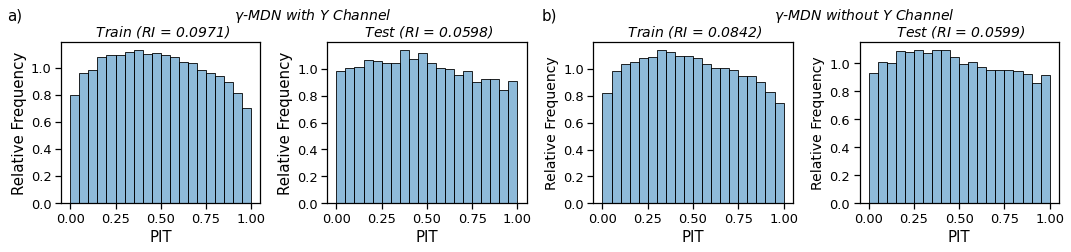

In [42]:
### With Y channel
# compute PIT and RI
# for the train
output=model_w.predict(X_train_w)  
F_t_train_w=PIT(Y_train_w,output)
RI_train_w=RI_metric(Y_train_w,output).numpy()

# for the test
output=model_w.predict(X_test_w) 
F_t_test_w=PIT(Y_test_w,output)
RI_test_w=RI_metric(Y_test_w,output).numpy()

### Without Y channel
# compute PIT and RI
# for the train
output=model_wo.predict(X_train_wo)  
F_t_train_wo=PIT(Y_train_wo,output)
RI_train_wo=RI_metric(Y_train_wo,output).numpy()

# for the test
output=model_wo.predict(X_test_wo) 
F_t_test_wo=PIT(Y_test_wo,output)
RI_test_wo=RI_metric(Y_test_wo,output).numpy()


fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

n_bins_train=20
sns.histplot(F_t_train_w.numpy(),
             bins=n_bins_train,
             stat="density",
             color = 'coral', 
             legend = False,
             ax=ax1)

n_bins_test=20
sns.histplot(F_t_test_w.numpy(), 
             bins=n_bins_test,
             stat="density",
             color = 'tab:blue',  
             legend = False,
             ax=ax2)

sns.histplot(F_t_train_wo.numpy(), 
             bins=n_bins_train, 
             stat="density",
             color = 'orange', 
             legend = False,
             ax=ax3)

n_bins_test=20
sns.histplot(F_t_test_wo.numpy(),  
             bins=n_bins_test, 
             stat="density",
             color = 'tab:blue', 
             legend = False,
             ax=ax4)

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)

ax1.set_xlabel('PIT', fontsize=15)
ax1.set_title(' Train ($RI$ = %.4f)' %(RI_train_w), style='italic', fontsize=14)
ax1.set_xlabel('PIT', fontsize=15)
ax2.set_title(' Test ($RI$ = %.4f)' %(RI_test_w), style='italic', fontsize=14)
ax1.set_ylabel('Relative Frequency', fontsize=15)
ax2.set_xlabel('PIT', fontsize=15)
ax2.set_ylabel('Relative Frequency', fontsize=15)

ax3.set_xlabel('PIT', fontsize=15)
ax3.set_title(' Train ($RI$ = %.4f)' %(RI_train_wo), style='italic', fontsize=14)
ax3.set_xlabel('PIT', fontsize=15)
ax4.set_title(' Test ($RI$ = %.4f)' %(RI_test_wo), style='italic', fontsize=14)
ax3.set_ylabel('Relative Frequency', fontsize=14)
ax4.set_xlabel('PIT', fontsize=15)
ax4.set_ylabel('Relative Frequency', fontsize=14)

ax1.tick_params(axis='y', labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax3.tick_params(axis='y', labelsize=13)
ax3.tick_params(axis='x', labelsize=13)
ax4.tick_params(axis='y', labelsize=13)
ax4.tick_params(axis='x', labelsize=13)

height = 0.97
fig.text(0.01, height, "a)", horizontalalignment='left', verticalalignment='center', fontsize=15)
fig.text(0.505, height, "b)", horizontalalignment='left', verticalalignment='center', fontsize=15)

fig.text(0.22, height, "$\gamma$-MDN with Y Channel", horizontalalignment='left', verticalalignment='center', fontsize=14, style='italic')
fig.text(0.72, height, "$\gamma$-MDN without Y Channel", horizontalalignment='left', verticalalignment='center', fontsize=14, style='italic')

plt.tight_layout()
#plt.savefig("PIT_train_wT.pdf")
plt.show()



The PIT histograms for the train sets in both cases (with and without using the Y channel) do not show uniform distributions. This is, the predictions are far from perfect. In any case, the reliability indices $RI$ (that measure the departure from uniformity) are not extremely bad, as they should be as close as possible to 0 in the range $[0,1.9]$. In particular, the PIT histograms present more weight in the middle. This can be related to excesively broad distributions (overdispersion). 

Surprisingly, both the PIT histograms and the $RI$ values for the test partitions in both cases are rather accurate, overall for the model without the Y channel. Could it be related to the number of samples in each dataset?

---
# Results
---


Once fitted, we can access the mixture coefficients for the training and test partitions

In [43]:
## with Y channel
# for the train
output=model_w.predict(X_train_w)
pi_tr_w, alpha_tr_w, beta_tr_w = get_mixture_coef_np(output)

# for the test
output=model_w.predict(X_test_w)
pi_ts_w, alpha_ts_w, beta_ts_w = get_mixture_coef_np(output)

## Without Y channel
# for the train
output=model_wo.predict(X_train_wo)
pi_tr_wo, alpha_tr_wo, beta_tr_wo = get_mixture_coef_np(output)

# for the test
output=model_wo.predict(X_test_wo)
pi_ts_wo, alpha_ts_wo, beta_ts_wo = get_mixture_coef_np(output)


665/665 [==============================] - 1s 2ms/step


We can store all these values, together with the mixutre PDF means, variance and standard deviations into dataframes. 

In [44]:
def pdf_mode(pis, alphas, betas):
    """ Helper function to find the mode of the mixture PDF"""
    
    # define mixture distribution
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=pis),
        components_distribution=tfd.Gamma(
            concentration=alphas,       
            rate=betas))

    # compute modes of each component
    modes = (alphas - 1.0) / betas
       
    # find value of mixture PDF at components modes
    isFirst=True
    for i in range(len(pis[0])):
      if isFirst:
        gm_modes = gm.prob(modes[:,0])
        isFirst=False
      else:
        gm_modes = np.vstack([gm_modes,gm.prob(modes[:,i])])
    
    # find argument of mode giving largest PDF
    mode_arg = np.argmax(gm_modes,axis=0)

    # find corresponding photo_z
    mode = np.ones(pis.shape[0])
    for i in range(pis.shape[0]):
      mode[i] = modes[i,mode_arg[i]]

    return mode

def return_df(pis, alphas, betas, Y_valid):
    """
    Given the output of the MDN, returns
    a DataFrame with mean, variance and stddev added
    and Coefficient of Variance (CoV)
    """
    pi_names = ['pi_' + str(i) for i in range(len(pis[0]))]
    alpha_names = ['alpha_' + str(i) for i in range(len(pis[0]))]
    beta_names = ['beta_' + str(i) for i in range(len(pis[0]))]
    means_names = ['mean_' + str(i) for i in range(len(pis[0]))]
    std_names = ['sdtdev_' + str(i) for i in range(len(pis[0]))]
    names = pi_names + alpha_names + beta_names + means_names + std_names
    temp = np.concatenate((pis, alphas, betas, alphas/betas, np.sqrt(alphas)/betas), axis=1)
    df = pd.DataFrame(temp, columns=names)
        
    variances = alphas/betas**2
    means = (alphas / betas) 
    modes = pdf_mode(pis,alphas,betas)
        
    df['Mode'] = modes
    df['Mean'] = np.average(means, weights=pis, axis=1)
    df['variance'] =  np.average(means**2 + variances**2, weights=pis, axis=1) - df['Mean'].values**2
    df['stddev'] = np.sqrt(df.variance)
    df['CoV'] = df['stddev']/df['Mean']
    df['redshift'] = Y_valid
    return df


In [45]:
## CRPS
# for the train
res_tr_w = return_df(pi_tr_w, alpha_tr_w, beta_tr_w, Y_train_w)
# for the test
res_ts_w = return_df(pi_ts_w, alpha_ts_w, beta_ts_w, Y_test_w)

## Log-likelihood
# for the train
res_tr_wo = return_df(pi_tr_wo, alpha_tr_wo, beta_tr_wo, Y_train_wo)
# for the test
res_ts_wo = return_df(pi_ts_wo, alpha_ts_wo, beta_ts_wo, Y_test_wo)

Let's inspect the look of one of these dataframes

In [46]:
res_ts_wo.head(5)

,pi_0,pi_1,pi_2,pi_3,pi_4,alpha_0,alpha_1,alpha_2,alpha_3,alpha_4,...,sdtdev_1,sdtdev_2,sdtdev_3,sdtdev_4,Mode,Mean,variance,stddev,CoV,redshift
0,0.000993,0.000779,0.223603,0.747643,0.026981,5.520164,17.839981,143.533401,92.333832,7.080761,...,0.073576,0.076411,0.116834,0.368669,1.110502,1.070889,0.009592,0.097939,0.091456,1.045600
1,0.732978,0.000016,0.000012,0.000352,0.266643,14.831723,15.851076,165.050491,63.109329,2.000000,...,0.021051,0.070336,0.049901,0.025306,0.038658,0.040078,0.000060,0.007739,0.193099,0.060614
2,0.903707,0.000019,0.000001,0.003784,0.092488,42.598743,39.029095,54.942097,42.451374,2.000000,...,0.022961,0.025091,0.031931,0.058353,0.094636,0.096001,0.000066,0.008138,0.084769,0.129800
3,0.000025,0.000800,0.030944,0.928147,0.040085,2.106065,31.085344,254.189438,180.037384,10.654579,...,0.048982,0.051598,0.094273,0.353275,1.257915,1.245949,0.007717,0.087844,0.070504,1.340000
4,0.000038,0.000041,0.996809,0.001524,0.001588,78.164124,88.208725,553.486511,168.101440,2.000001,...,0.055402,0.036264,0.058588,0.646553,0.851609,0.853068,0.000317,0.017801,0.020866,0.862857


Let's check for a moment the distribution of priors (mixture weiths):

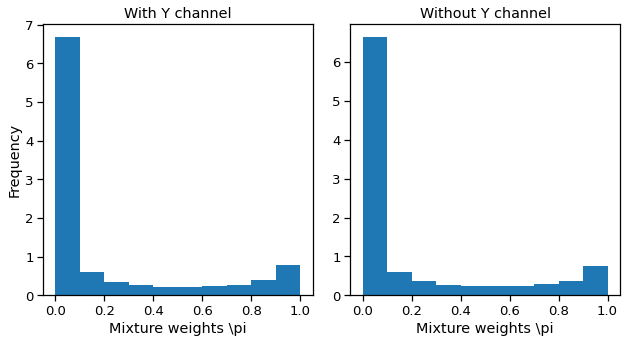

In [47]:
fig, ax = plt.subplots(1,2, figsize=(9,5))
ax[0].hist(pi_ts_w.flatten(), density=True)
ax[1].hist(pi_ts_wo.flatten(), density=True)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Mixture weights \pi')
ax[1].set_xlabel('Mixture weights \pi')
ax[0].set_title('With Y channel')
ax[1].set_title('Without Y channel')
plt.tight_layout()
plt.show()

There are note very clear differences, but in both cases, most of the cases are either at 0 or, secondarily, at 1. This means that for most observations, less than 5 mixture components are needed to describe the red-shifts PDF. In addition, that there are so many values close to 1 means that many observations are fairly well described by a single mixture component.

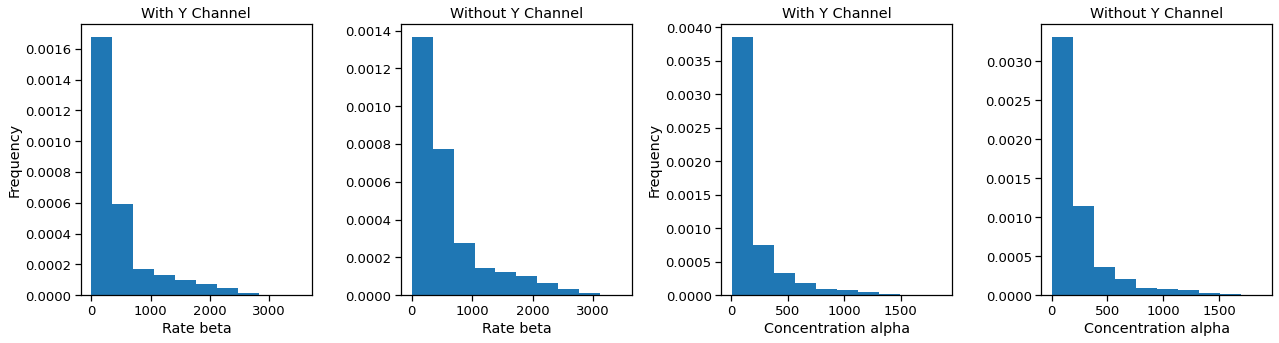

In [48]:
fig, ax = plt.subplots(1,4, figsize=(18,5))
ax[0].hist(beta_ts_w.flatten(), density=True)
ax[1].hist(beta_ts_wo.flatten(), density=True)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Rate beta')
ax[1].set_xlabel('Rate beta')
ax[0].set_title('With Y Channel')
ax[1].set_title('Without Y Channel')

ax[2].hist(alpha_ts_w.flatten(), density=True)
ax[3].hist(alpha_ts_wo.flatten(), density=True)
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Concentration alpha')
ax[3].set_xlabel('Concentration alpha')
ax[2].set_title('With Y Channel')
ax[3].set_title('Without Y Channel')
plt.tight_layout()
plt.show()

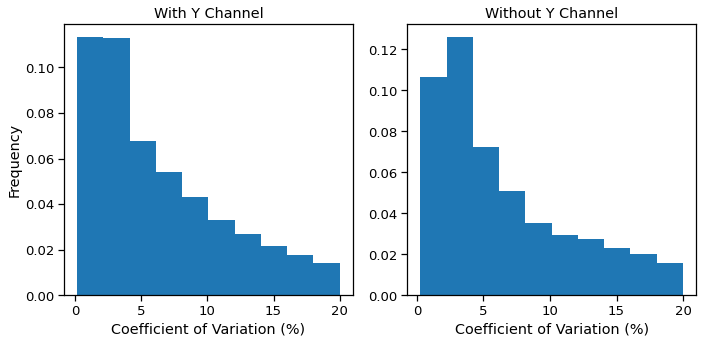

In [49]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
CoV_w=res_ts_w['stddev']/res_ts_w['Mean']*100
CoV_wo=res_ts_wo['stddev']/res_ts_wo['Mean']*100
ax[0].hist(CoV_w[CoV_w<20], density=True)
ax[1].hist(CoV_wo[CoV_wo<20], density=True)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Coefficient of Variation (%)')
ax[1].set_xlabel('Coefficient of Variation (%)')
ax[0].set_title('With Y Channel')
ax[1].set_title('Without Y Channel')

plt.tight_layout()

In [50]:
CoV_w_trun=CoV_w[CoV_w<20].copy()
CoV_wo_trun=CoV_wo[CoV_wo<20].copy()

In [51]:
CoV_wo.shape

(21250,)

In [52]:
CoV_wo_trun.shape

(17750,)

## Examples of predicted PDFs
---

Let see how the MDNs models trained with the two losses functions predict the probability distribution functions (PDF) for some random galaxies of the test partition.

In [56]:
def plot_gamma_mix(pis, alphas, betas, ax, color='red', comp=True):
    """
    Plots the mixture of gamma models to axis=ax
    """
    x = np.linspace(0.0, 5, 600)
    final = np.zeros_like(x)
    for i, (weight_mix, alpha_mix, beta_mix) in enumerate(zip(pis, alphas, betas)):
        dist = tfd.Gamma(concentration=alpha_mix, rate=beta_mix)
        pdf = dist.prob(x)
        temp = pdf.numpy() * weight_mix
        final = final + temp
    ax.plot(x, final, c=color)

**Figure 6: Comparision of PDFs predicted with and without using the Y channel**

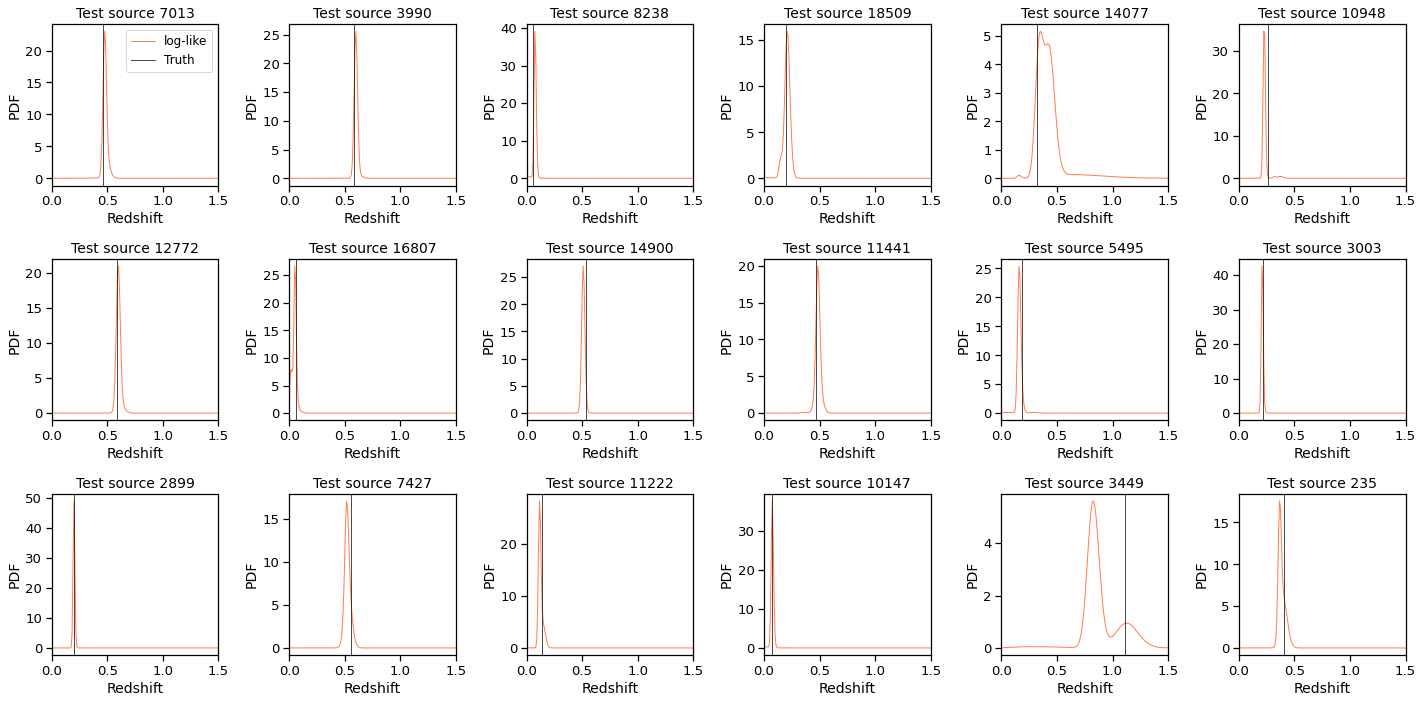

In [60]:
num_cols=6
num_rows=3
num_gal=num_cols*num_rows
gal_id = np.random.randint(1,len(Y_test_wo),num_gal)


#pi_ts_wo, alpha_ts_wo, beta_ts_wo

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))
count = 0
for i in range(num_rows):
  for j in range(num_cols):
    plot_gamma_mix(pi_ts_wo[gal_id][count], alpha_ts_wo[gal_id][count], beta_ts_wo[gal_id][count], axes[i,j], 'coral') 
    axes[i, j].axvline(x=Y_test_wo[gal_id[count]], color='black', alpha=0.7)
    axes[i, j].set_xlim(0,1.5)
    axes[i, j].set_ylabel('PDF', fontsize=14)
    axes[i, j].set_title('Test source ' + str(gal_id[count]), fontsize=14)
    axes[i, j].set_xlabel('Redshift', fontsize=14)
    count += 1    

axes[0, 0].legend(['log-like', 'Truth'], loc ='best', fontsize=12)
fig.tight_layout()

Both models seem to perform quite similarly, as the peak of the predicted redshift distributions falls close to the true redshift.




Let's represent the predicted PDFs for those galaxies of the test set which have the greatest "multimodality" (largest mixture global variance)

**Figure 7: Examples of PDFs with large uncertainties** 

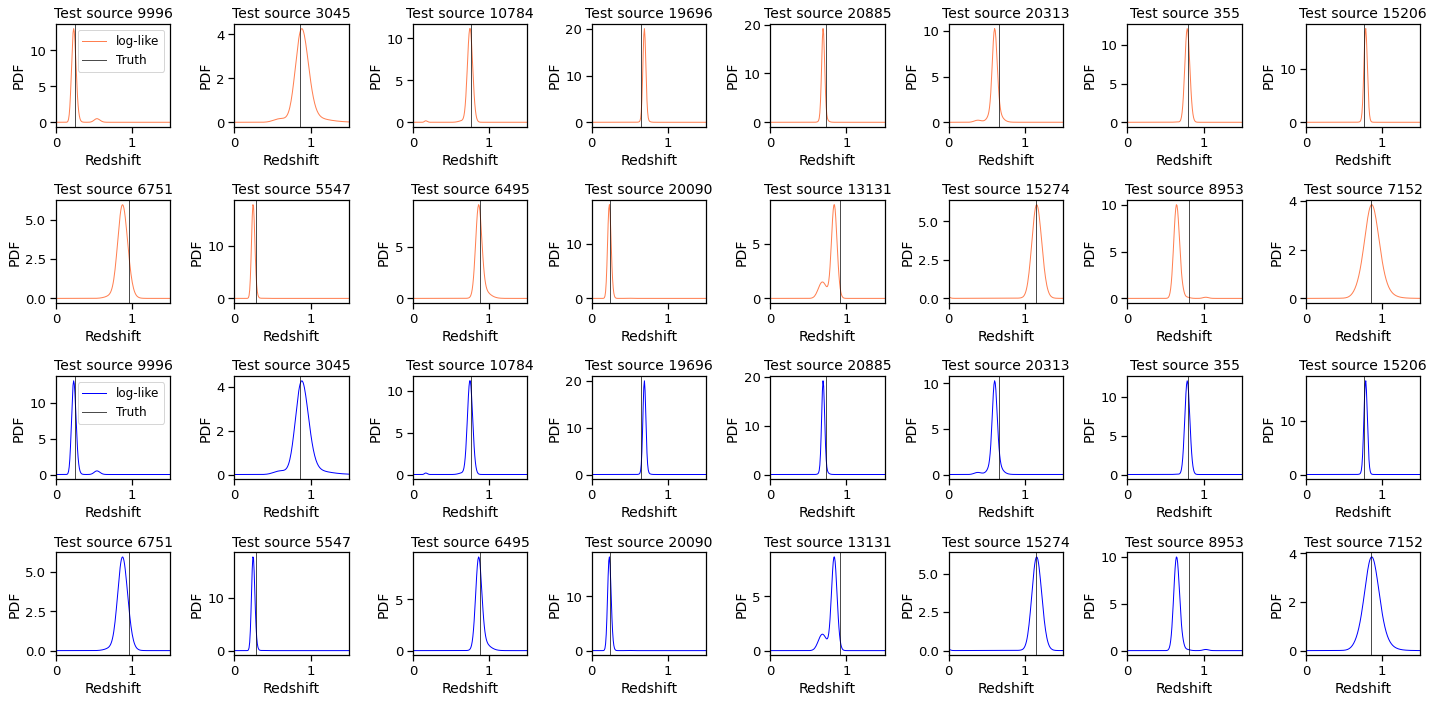

In [66]:
num_cols=8
num_rows=4
num_gal=int(num_cols*num_rows/2)

## In terms of CRPS
variance_wo=res_ts_wo['variance'].values
i_sort_wo=np.argsort(variance_wo)


# galaxies IDs
gal_id_wo = i_sort_wo[-num_gal:]

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))
count_wo = 0
count_ll = 0

for i in range(num_rows):
  for j in range(num_cols):
    if i<num_rows/2:
      plot_gamma_mix(pi_ts_wo[gal_id_wo][count_wo], alpha_ts_wo[gal_id_wo][count_wo],
                     beta_ts_wo[gal_id_wo][count_wo], axes[i,j], 'coral')  
      axes[i, j].axvline(x=Y_test_wo[gal_id_wo[count_wo]], color='black', alpha=0.7)
      axes[i, j].set_ylabel('PDF', fontsize=14)
      axes[i, j].set_title('Test source ' + str(gal_id_wo[count_wo]), fontsize=14)
      axes[i, j].set_xlabel('Redshift', fontsize=14)
      axes[i, j].set_xlim(0,1.5)

      count_wo += 1
    else:
      plot_gamma_mix(pi_ts_wo[gal_id_wo][count_ll], alpha_ts_wo[gal_id_wo][count_ll], 
                     beta_ts_wo[gal_id_wo][count_ll], axes[i,j], 'blue')  
      axes[i, j].axvline(x=Y_test_wo[gal_id_wo[count_ll]], color='black', alpha=0.7)
      axes[i, j].set_ylabel('PDF', fontsize=14)
      axes[i, j].set_title('Test source ' + str(gal_id_wo[count_ll]), fontsize=14)
      axes[i, j].set_xlabel('Redshift', fontsize=14)
      axes[i, j].set_xlim(0,1.5)

      count_ll += 1

axes[0, 0].legend(['log-like', 'Truth'], loc ='upper right', fontsize=12)
axes[2, 0].legend(['log-like', 'Truth'], loc ='upper right', fontsize=12)
fig.tight_layout()


## Mean of predicted redshift distribution vs. true redshift
---

How well are we able to retrieve the true redshift? 

**Figure 8: Mean of the predicted redshifts PDF vs actual redshift** 



/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


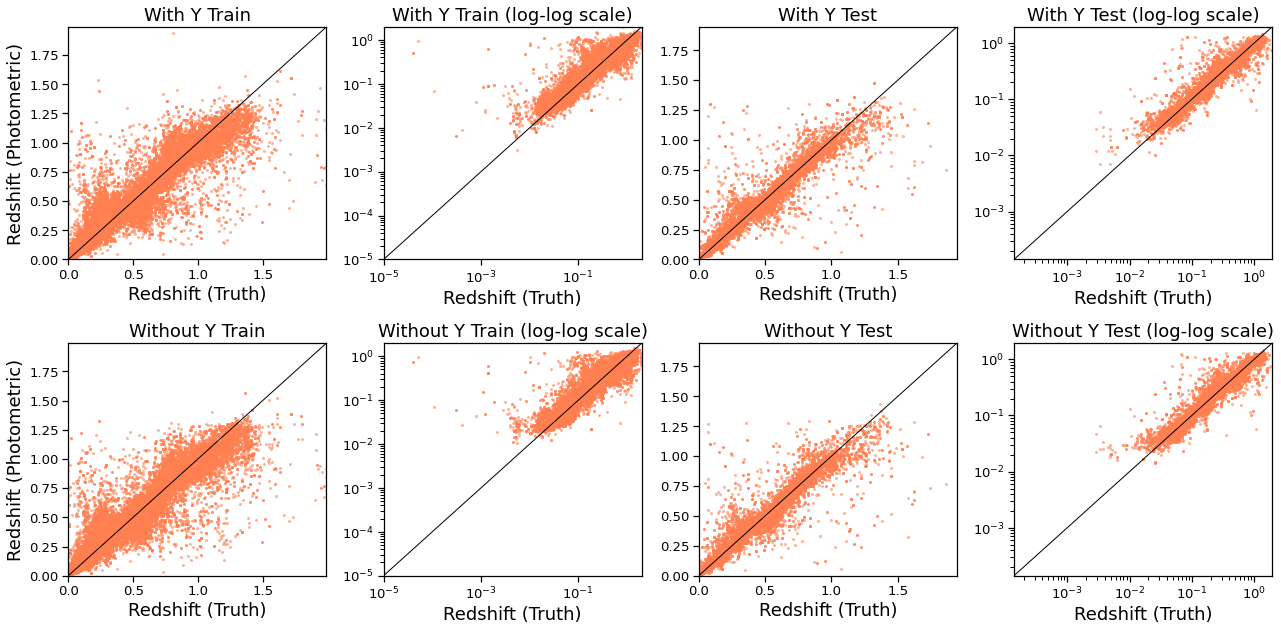

In [69]:
# plot all test predictions and 5 times as much train predictions
Y_test=Y_test_w
Y_train=Y_train_w

amount = len(Y_test) 
p_ind_train = np.random.randint(0,len(Y_train),5*amount)
p_ind_test = np.random.randint(0,len(Y_test),amount)


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 9))
## With Y channel
# mean
axes[0,0].scatter(Y_train[p_ind_train], res_tr_w['Mean'].iloc[p_ind_train],
                alpha=0.5,s=4, c='coral')
axes[0,1].scatter(Y_train[p_ind_train], res_tr_w['Mean'].iloc[p_ind_train],
                alpha=0.5,s=4, c='coral')
axes[0,2].scatter(Y_test[p_ind_test], res_ts_w['Mean'].iloc[p_ind_test],
                alpha=0.5,s=4, c='coral')
axes[0,3].scatter(Y_test[p_ind_test], res_ts_w['Mean'].iloc[p_ind_test],
                alpha=0.5,s=4, c='coral')


## With Y channel
# mean
axes[1,0].scatter(Y_train[p_ind_train], res_tr_wo['Mean'].iloc[p_ind_train],
                alpha=0.5,s=4, c='coral')
axes[1,1].scatter(Y_train[p_ind_train], res_tr_wo['Mean'].iloc[p_ind_train],
                alpha=0.5,s=4, c='coral')
axes[1,2].scatter(Y_test[p_ind_test], res_ts_wo['Mean'].iloc[p_ind_test],
                alpha=0.5,s=4, c='coral')
axes[1,3].scatter(Y_test[p_ind_test], res_ts_wo['Mean'].iloc[p_ind_test],
                alpha=0.5,s=4, c='coral')


# add bisector lines
axes[0,0].plot([0, max(Y_train)], [0, max(Y_train)], linewidth=1, color='k')
axes[0,1].plot([0, max(Y_test)], [0, max(Y_test)], linewidth=1, color='k')
axes[0,2].plot([0, max(Y_train)], [0, max(Y_train)], linewidth=1, color='k')
axes[0,3].plot([0, max(Y_test)], [0, max(Y_test)], linewidth=1, color='k')

axes[1,0].plot([0, max(Y_train)], [0, max(Y_train)], linewidth=1, color='k')
axes[1,1].plot([0, max(Y_test)], [0, max(Y_test)], linewidth=1, color='k')
axes[1,2].plot([0, max(Y_train)], [0, max(Y_train)], linewidth=1, color='k')
axes[1,3].plot([0, max(Y_test)], [0, max(Y_test)], linewidth=1, color='k')

# set axis limints
axes[0,0].set_xlim(0, max(Y_train))
axes[0,0].set_ylim(0, max(Y_train))
axes[0,1].set_xlim(min(Y_train), max(Y_train))
axes[0,1].set_ylim(min(Y_train), max(Y_train))
axes[0,2].set_xlim(0, max(Y_test))
axes[0,2].set_ylim(0, max(Y_test))
axes[0,3].set_xlim(min(Y_test), max(Y_test))
axes[0,3].set_ylim(min(Y_test), max(Y_test))
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,3].set_xscale('log')
axes[0,3].set_yscale('log')

axes[1,0].set_xlim(0, max(Y_train))
axes[1,0].set_ylim(0, max(Y_train))
axes[1,1].set_xlim(min(Y_train), max(Y_train))
axes[1,1].set_ylim(min(Y_train), max(Y_train))
axes[1,2].set_xlim(0, max(Y_test))
axes[1,2].set_ylim(0, max(Y_test))
axes[1,3].set_xlim(min(Y_test), max(Y_test))
axes[1,3].set_ylim(min(Y_test), max(Y_test))
axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log')
axes[1,3].set_xscale('log')
axes[1,3].set_yscale('log')

# add title and axis labels
axes[0,0].set_title('With Y Train', fontsize=18)
axes[0,1].set_title('With Y Train (log-log scale)', fontsize=18)
axes[0,2].set_title('With Y Test', fontsize=18)
axes[0,3].set_title('With Y Test (log-log scale)', fontsize=18)

axes[0,0].set_xlabel('Redshift (Truth)', fontsize=18)
axes[0,1].set_xlabel('Redshift (Truth)', fontsize=18)
axes[0,2].set_xlabel('Redshift (Truth)', fontsize=18)
axes[0,3].set_xlabel('Redshift (Truth)', fontsize=18)

axes[0,0].set_ylabel('Redshift (Photometric)', fontsize=18)

axes[1,0].set_title('Without Y Train', fontsize=18)
axes[1,1].set_title('Without Y Train (log-log scale)', fontsize=18)
axes[1,2].set_title('Without Y Test', fontsize=18)
axes[1,3].set_title('Without Y Test (log-log scale)', fontsize=18)

axes[1,0].set_xlabel('Redshift (Truth)', fontsize=18)
axes[1,1].set_xlabel('Redshift (Truth)', fontsize=18)
axes[1,2].set_xlabel('Redshift (Truth)', fontsize=18)
axes[1,3].set_xlabel('Redshift (Truth)', fontsize=18)

axes[1,0].set_ylabel('Redshift (Photometric)', fontsize=18)
fig.tight_layout()
plt.show()

Both models seem to perform very similarly, as the spread of the scatters around the bisector line (perfect prediction) is apparently the same. 

The galaxies with true redshifts above 1.25 are predicted terribly bad in both models, but this can be due to the tiny number of observations in this range (see redshift histogram at the beginning of the report, Figure 1). The same happens for the galaxies (stars, maybe) with redshifts below 0.01.

But in general, the performance is quite satisfactory.

## PDFs heat-maps

Instead of representing simply the means, we can plot a heat-map to show the predicted PDFs (for some galaxies):

In [70]:
def plot_heat_map(pis, alphas, betas, ys, num_seg, color_map, ax):
  count=0
  # devide Y values in num_seg segments
  segment=(np.max(ys)-np.min(ys))/num_seg
  # store index of non ordered Ys
  index_y=np.arange(len(ys))
  # array to store indeces of "equispaced" Y values, negative if no value
  i_equi=-np.ones(num_seg)
  for i in range(num_seg):
    # select lower and upper limits of i segment
    z_l=count*segment+np.min(ys)
    count += 1
    z_u=count*segment+np.min(ys)
    # select indeces of sources with Y values between z_l and z_u
    i_trun=index_y[(ys>z_l).flatten() & (ys<z_u).flatten()]
    # if this array is not empty, select one of those randomly
    if i_trun.size != 0:
      i_equi[i]=int(i_trun[np.random.randint(0,len(i_trun),1)])
  i_equi=i_equi.astype(int)

  # initialize heat-map
  heat = np.zeros((num_seg,num_seg))
  # For each of those sources, plot the PDF
  y_ph_z = np.linspace(0.0, np.max(ys), num_seg)
  for j in range(num_seg):
    if i_equi[j]!=-1: # if the array is not empty
      final = np.zeros_like(y_ph_z)
      for i, (weight_mix, alpha_mix, beta_mix) in enumerate(zip(pis[i_equi[j],:], alphas[i_equi[j],:], betas[i_equi[j],:])):
        dist = tfd.Gamma(concentration=alpha_mix, rate=beta_mix)
        pdf = dist.prob(y_ph_z)
        temp = pdf.numpy() * weight_mix
        final = final + temp
      heat[:,j] = final/np.max(final)
    else:
      heat[:,j] = np.zeros_like(y_ph_z)
      
  ax.imshow(heat,cmap=color_map,origin='lower',extent=[0,max(ys),0,max(ys)])
  ax.set_xticks(np.arange(0,4.5,0.5))
  ax.set_yticks(np.arange(0,4.5,0.5))
  ax.plot([0, max(ys)], [0, max(ys)], linewidth=1, color='k')


**Figure 9: Heat-maps displaying the distribution of photo-z vs actual z**

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_base.py:2480: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xys = np.asarray(xys)


TypeError: ignored

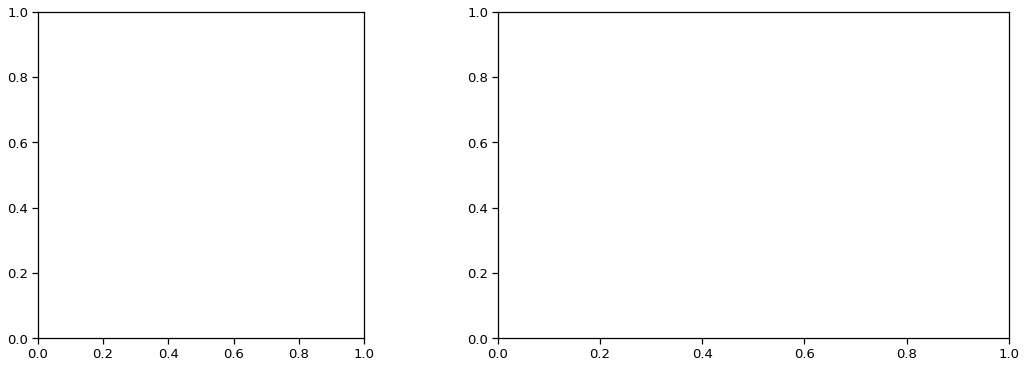

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), constrained_layout=True)
np.random.seed(1004)
num_seg=4000

## log-likelihood K=1
plot_heat_map(pi_ts_w,alpha_ts_w,beta_ts_w,Y_test, num_seg, 'Oranges', axes[0])

## log-likelihood K=5
plot_heat_map(pi_ts_wo,alpha_ts_wo,beta_ts_wo,Y_test, num_seg, 'Oranges', axes[1])

axes[0].set_title('$\gamma$-MDN with Y channel', fontsize=14, style='italic')
axes[1].set_title('$\gamma$-MDN without Y channel' , fontsize=14, style='italic')

axes[0].set_xlabel('Redshift (Truth)', fontsize=15)
axes[1].set_xlabel('Redshift (Truth)', fontsize=15)

axes[0].set_ylabel('Redshift (Photometric)', fontsize=15)
axes[1].set_ylabel('Redshift (Photometric)', fontsize=15)

axes[0].tick_params(axis='y', labelsize=13)
axes[0].tick_params(axis='x', labelsize=13)
axes[1].tick_params(axis='y', labelsize=13)
axes[1].tick_params(axis='x', labelsize=13)

#plt.savefig("PDFs_heatmaps_wT.pdf")
plt.show()

In these plots, it can be seen that the predicted distributions for redshifts above 1 start to get broader and broader. This means that the uncertinty is higher. This makes sense, as the number of observations above 1 is quite reduced, and the MDN is not capable to learn properly.

---
# Final Models training
---

In [72]:
steps = [('scaler', RobustScaler()), ('pca', PCA())]

# Reinitiate the transformer pipeline
steps_w = [('scaler', RobustScaler()), ('pca', PCA())]

steps_wo = [('scaler', RobustScaler()), ('pca', PCA())]

pipeline_w = Pipeline(steps_w)

pipeline_wo = Pipeline(steps_wo)



## Model with Y channel

In [73]:
checkpoint_path = "/content/drive/MyDrive/PDFphotoz/aure_original_final_callback_withY.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

# transform the features
Xtrain_w = pipeline_w.fit_transform(Xw)

# Initialize and compile model (do not comput RI, it crashes)
model_w = Gamma_MDN(K, n_hidden_1, gm_ll_loss, Xtrain_w.shape[1], True)

# fit the model with the optimal number of epochs

n_epoch=850

with tf.device('/device:GPU:0'):
    history_w=model_w.fit(Xtrain_w, yw, 
                      epochs=n_epoch,
                      batch_size = batch_size,
                      verbose=1,
                      callbacks=[cp_callback])

Epoch 1/850
277/277 [==============================] - 4s 7ms/step - loss: 0.0513 - RI_metric: 0.9316
Epoch 2/850
277/277 [==============================] - 2s 6ms/step - loss: -0.6978 - RI_metric: 0.9101
Epoch 3/850
277/277 [==============================] - 2s 7ms/step - loss: -0.9010 - RI_metric: 0.9445
Epoch 4/850
277/277 [==============================] - 2s 7ms/step - loss: -1.0363 - RI_metric: 0.9466
Epoch 5/850
277/277 [==============================] - 2s 8ms/step - loss: -1.1566 - RI_metric: 0.9046
Epoch 6/850
277/277 [==============================] - 2s 6ms/step - loss: -1.2567 - RI_metric: 0.8666
Epoch 7/850
277/277 [==============================] - 2s 6ms/step - loss: -1.3386 - RI_metric: 0.8279
Epoch 8/850
277/277 [==============================] - 2s 6ms/step - loss: -1.4088 - RI_metric: 0.7822
Epoch 9/850
277/277 [==============================] - 2s 6ms/step - loss: -1.4692 - RI_metric: 0.7481
Epoch 10/850
277/277 [==============================] - 2s 6ms/step - loss

## Model without Y channel

In [74]:
checkpoint_path = "/content/drive/MyDrive/PDFphotoz/aure_original_final_callback_noY.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

# transform the features
Xtrain_wo = pipeline_wo.fit_transform(Xwo)

# Initialize and compile model (do not comput RI, it crashes)
model_wo = Gamma_MDN(K, n_hidden_1, gm_ll_loss, Xtrain_wo.shape[1], True)

# fit the model with the optimal number of epochs

n_epoch=850

with tf.device('/device:GPU:0'):
    history_wo=model_wo.fit(Xtrain_wo, ywo, 
                      epochs=n_epoch,
                      batch_size = batch_size,
                      verbose=1,
                      callbacks=[cp_callback])

Epoch 1/850
277/277 [==============================] - 4s 6ms/step - loss: 0.0012 - RI_metric: 0.9361
Epoch 2/850
277/277 [==============================] - 2s 6ms/step - loss: -0.6981 - RI_metric: 0.9130
Epoch 3/850
277/277 [==============================] - 2s 7ms/step - loss: -0.9062 - RI_metric: 0.9523
Epoch 4/850
277/277 [==============================] - 2s 7ms/step - loss: -1.0696 - RI_metric: 0.9386
Epoch 5/850
277/277 [==============================] - 2s 7ms/step - loss: -1.1920 - RI_metric: 0.8928
Epoch 6/850
277/277 [==============================] - 2s 6ms/step - loss: -1.2875 - RI_metric: 0.8490
Epoch 7/850
277/277 [==============================] - 2s 6ms/step - loss: -1.3653 - RI_metric: 0.8056
Epoch 8/850
277/277 [==============================] - 2s 6ms/step - loss: -1.4301 - RI_metric: 0.7669
Epoch 9/850
277/277 [==============================] - 2s 6ms/step - loss: -1.4856 - RI_metric: 0.7332
Epoch 10/850
277/277 [==============================] - 2s 8ms/step - loss

---
# Making predictions in the validation set
---

## Feature Selection and engineering
---

In [ ]:
feat_sel = ['COADD_OBJECT_ID','Z','SOF_CM_T','SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z', 'MAG_AUTO_CORRECTED_Y', 'ERR_Z', 'SOF_CM_T_ERR','SOF_CM_MAG_ERR_G', 'SOF_CM_MAG_ERR_R', 'SOF_CM_MAG_ERR_I', 'SOF_CM_MAG_ERR_Z', 'MAGERR_AUTO_Y', 'ZMEAN_Y4']
df_test = test_data_set[feat_sel]

### Remove galaxies with magnitude errors < 0 and small redshifts (stars)
df_test = df_test[(df_test.Z<2) &
                    (df_test.SOF_CM_MAG_ERR_G>0.) &
                    (df_test.SOF_CM_MAG_ERR_R>0.) &
                    (df_test.SOF_CM_MAG_ERR_I>0.) &
                    (df_test.SOF_CM_MAG_ERR_Z>0.) &
                    (df_test.MAG_AUTO_CORRECTED_Y>0.) &
                    (df_test.MAG_AUTO_CORRECTED_Y<40.) &
                    (df_test.SOF_CM_T>0.)]

# let's change the column names for convenience
feat_names = {'COADD_OBJECT_ID': 'id','Z': 'redshift','SOF_CM_T': 'T','SOF_CM_MAG_CORRECTED_G': 'g', 'SOF_CM_MAG_CORRECTED_R': 'r', 'SOF_CM_MAG_CORRECTED_I': 'i', 'SOF_CM_MAG_CORRECTED_Z': 'z', 'MAG_AUTO_CORRECTED_Y': 'Y', 'ERR_Z': 'redshift_err', 'SOF_CM_MAG_ERR_G': 'g_err', 'SOF_CM_MAG_ERR_R': 'r_err', 'SOF_CM_MAG_ERR_I': 'i_err', 'SOF_CM_MAG_ERR_Z': 'z_err', 'MAGERR_AUTO_Y': 'Y_err', 'ZMEAN_Y4': 'ZMEAN_Y4'}
df_test=df_test.rename(columns=feat_names)


Add columns with color differences ($g-r,g-i,\ldots$)

In [ ]:
df_test_aug = df_test[['id','ZMEAN_Y4','redshift','T','g','r','i','z','Y']].copy()
col_names = ['g','r','i','z','Y']
for i in range(len(col_names)-1):
  for j in range(i+1,len(col_names)):
      df_test_aug[col_names[i]+'-'+col_names[j]]= df_test_aug[col_names[i]]-df_test_aug[col_names[j]]

The errors are highly right skewed (not shown). Correspondingly, we will work with their log10. But we won't change the column name for economy of notation

In [ ]:
# take log10 of magnitude errors
feats = ['T']
df_test_aug[feats]=np.log10(df_test_aug[feats])

In [ ]:
# dataframe with Y channel (w)
#df_test_wY = df_test_aug.copy()

# dataframe without Y channel (woY)
df_test_woY = df_test_aug.drop(['Y','g-Y','r-Y','i-Y','z-Y'], axis=1)

### The training features with Y channel ###
#feat_test = list(df_test_wY)
#X_ts_w = df_test_wY[feat_test[3:]].to_numpy()

### The training features without Y channel ###
feat_test = list(df_test_woY)
X_ts_wo = df_test_woY[feat_test[3:]].to_numpy()

### Target variable and DNF prediction
y_ts = df_test_woY.redshift.to_numpy()
y_ts = y_ts[:,np.newaxis]
y_dnf = df_test.ZMEAN_Y4.to_numpy()
y_dnf = y_dnf[:,np.newaxis]


## Predicted distributions
---

In [ ]:
## with Y channel

#output_w=model_w.predict(pipeline_w.transform(X_ts_w))
#pi_ts_w, alpha_ts_w, beta_ts_w = get_mixture_coef_np(output_w)

## Without Y channel

output_wo=model_wo.predict(pipeline_wo.transform(X_ts_wo))
pi_ts_wo, alpha_ts_wo, beta_ts_wo = get_mixture_coef_np(output_wo)

In [ ]:
def return_df_bis(pis, alphas, betas, Y_valid, Y_dnf):
    """
    Given the output of the MDN, returns
    a DataFrame with mean, variance and stddev added
    """
    pi_names = ['pi_' + str(i) for i in range(len(pis[0]))]
    alpha_names = ['alpha_' + str(i) for i in range(len(pis[0]))]
    beta_names = ['beta_' + str(i) for i in range(len(pis[0]))]
    means_names = ['mean_' + str(i) for i in range(len(pis[0]))]
    std_names = ['sdtdev_' + str(i) for i in range(len(pis[0]))]
    names = pi_names + alpha_names + beta_names + means_names + std_names
    temp = np.concatenate((pis, alphas, betas, alphas/betas, np.sqrt(alphas)/betas), axis=1)
    df = pd.DataFrame(temp, columns=names)
    
    variances = alphas/betas**2
    means = (alphas / betas)
    modes = pdf_mode(pis,alphas,betas)
        
    df['Mode'] = modes    
    df['Mean'] = np.average(means, weights=pis, axis=1)
    df['variance'] =  np.average(means**2 + variances**2, weights=pis, axis=1) - df['Mean'].values**2
    df['stddev'] = np.sqrt(df.variance)
    df['redshift'] = Y_valid
    df['ZMEAN_Y4'] = Y_dnf
    return df

def plot_gamma_mix(pis, alphas, betas):
    """
    Plots the mixture of gamma models to axis=ax
    """
    x = np.linspace(0.0, 4, 600)
    final = np.zeros_like(x)
    for i, (weight_mix, alpha_mix, beta_mix) in enumerate(zip(pis, alphas, betas)):
        dist = tfd.Gamma(concentration=alpha_mix, rate=beta_mix)
        pdf = dist.prob(x)
        temp = pdf.numpy() * weight_mix
        final = final + temp
    return x,final
    #ax.plot(x, final, c=color)

In [ ]:
## With Y channel
#res_ts_w = return_df_bis(pi_ts_w, alpha_ts_w, beta_ts_w, y_ts,y_dnf)

## Without Y channel
res_ts_wo = return_df_bis(pi_ts_wo, alpha_ts_wo, beta_ts_wo, y_ts,y_dnf)


In [ ]:
print(pi_ts_wo.shape, alpha_ts_wo.shape, beta_ts_wo.shape)
print(pi_ts_wo[0])
#res_ts_wo_pdf = plot_gamma_mix(pi_ts_wo, alpha_ts_wo, beta_ts_wo)
pdf_file = open('pdfs_save.txt','w')
pdf_file.write('#pi_1 pi_2 pi_3 pi_4 pi_5 alpha_0 alpha_1 alpha_2 alpha_3 alpha_4 alpha_5 beta_0 beta_1 beta_2 beta_3 beta_4 beta_5\n')
for i in range(238639):
  pdf_file.write('%.10f %.10f %.10f %.10f %.10f %.10f %.10f %.10f %.10f %.10f %.10f %.10f %.10f %.10f %.10f\n'%(pi_ts_wo[i][0], pi_ts_wo[i][1], pi_ts_wo[i][2], pi_ts_wo[i][3], pi_ts_wo[i][4], alpha_ts_wo[i][0], alpha_ts_wo[i][1], alpha_ts_wo[i][2], alpha_ts_wo[i][3], alpha_ts_wo[i][4], beta_ts_wo[i][0], beta_ts_wo[i][1], beta_ts_wo[i][2], beta_ts_wo[i][3], beta_ts_wo[i][4]))
pdf_file.close()

(238639, 5) (238639, 5) (238639, 5)
[1.1704108e-07 2.2334415e-01 7.6465654e-01 1.1998844e-02 3.5585199e-07]


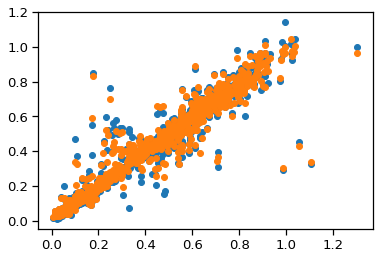

In [ ]:
amount=1000
plt.scatter(res_ts_wo.redshift.iloc[:amount],res_ts_wo.ZMEAN_Y4.iloc[:amount])
plt.scatter(res_ts_wo.redshift.iloc[:amount],res_ts_wo.Mean.iloc[:amount])
#plt.scatter(res_ts_w.redshift.iloc[:amount],res_ts_w.Mean.iloc[:amount])
plt.show()

**Figure 10: Evaluation of prediction precission and correctness**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


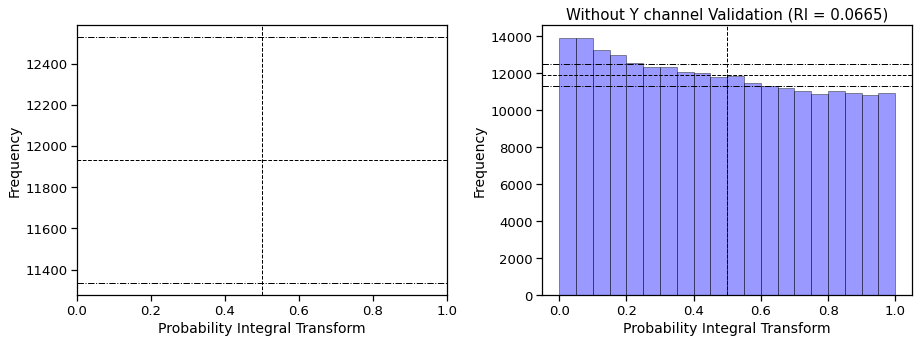

In [ ]:
#F_t_test_w=PIT(y_ts,output_w)
#RI_test_w=RI_metric(y_ts,output_w).numpy()

F_t_test_wo=PIT(y_ts,output_wo)
RI_test_wo=RI_metric(y_ts,output_wo).numpy()

fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

n_bins=20
#sns.distplot(F_t_test_w.numpy(), hist=True, kde=False, 
#             bins=n_bins, color = 'orange',
#             hist_kws={'edgecolor':'black'}, ax=ax1)

n_bins=20
sns.distplot(F_t_test_wo.numpy(), hist=True, kde=False, 
             bins=n_bins, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=ax2)

# Perfectly callibrated fit together with 90% CI
ax1.axhline(y=len(y_ts)/n_bins, linestyle='--', color='black', alpha=1)
ax1.axhline(y=0.95*len(y_ts)/n_bins, linestyle='-.', color='black', alpha=1)
ax1.axhline(y=1.05*len(y_ts)/n_bins, linestyle='-.', color='black', alpha=1)
ax1.axvline(x=0.5,linestyle='--', color='black', alpha=1)
ax2.axhline(y=len(y_ts)/n_bins, linestyle='--', color='black', alpha=1)
ax2.axhline(y=0.95*len(y_ts)/n_bins, linestyle='-.', color='black', alpha=1)
ax2.axhline(y=1.05*len(y_ts)/n_bins, linestyle='-.', color='black', alpha=1)
ax2.axvline(x=0.5,linestyle='--', color='black', alpha=1)

ax1.set_xlabel('Probability Integral Transform', fontsize=14)
#ax1.set_title('With Y channel Validation (RI = %.4f)' %(RI_test_w), fontsize=15)
ax1.set_xlabel('Probability Integral Transform', fontsize=14)
ax2.set_title('Without Y channel Validation (RI = %.4f)' %(RI_test_wo), fontsize=15)
ax1.set_ylabel('Frequency', fontsize=14)
ax2.set_xlabel('Probability Integral Transform', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()

plt.show()

In this case, it is clear from the PIT histogram and the RI value that the predictions performed with the model using the Y channel are a disaster, as they are highly biased. In contrast, the predictions withouth the Y channel are quite satisfactory.

We can understand better what it is happening if we represent the PIT histograms at different ranges of red-shifts.

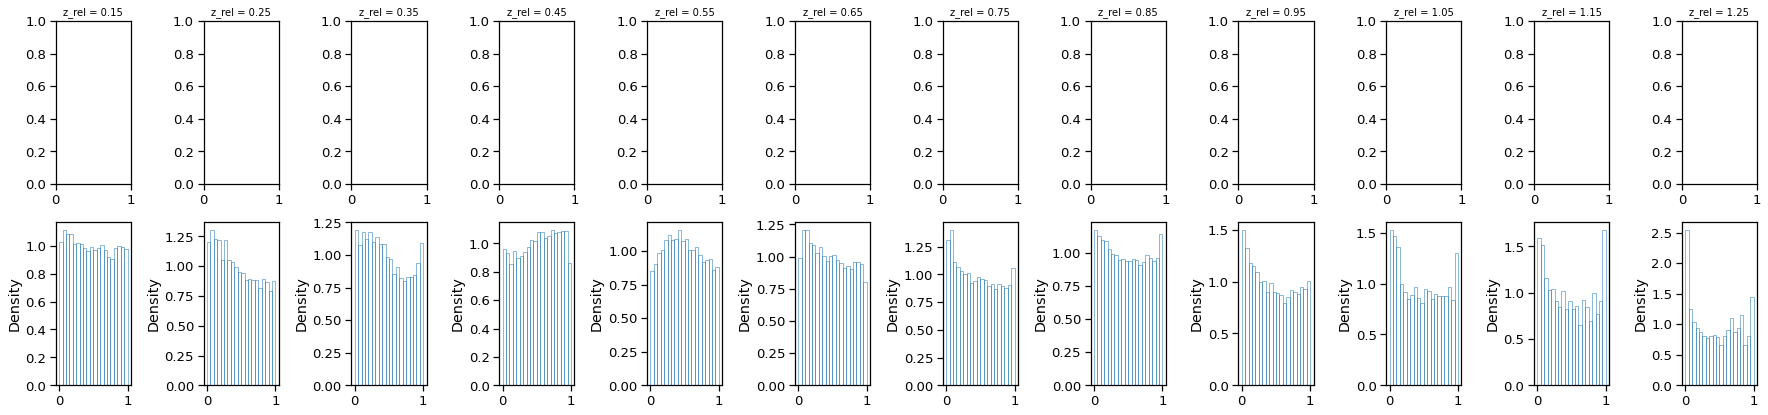

In [ ]:
redshift_bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

redshift_bins= np.arange(0.1,1.4,0.1)

#redshift_bins =[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

#photo_z_w = res_ts_w['Mean'].to_numpy()

photo_z_wo = res_ts_wo['Mean'].to_numpy()

dimension = len(redshift_bins)-1

z_rel = np.zeros(dimension)

RI_w = np.zeros(dimension)

RI_wo = np.zeros(dimension)

fig, ax = plt.subplots(2,dimension,figsize=(25,6))


for i1 in range(dimension):
      
      z_rel[i1] = (redshift_bins[i1]+redshift_bins[i1+1])/2.
      
      #zmask_w = (photo_z_w >= redshift_bins[i1])*(photo_z_w < redshift_bins[i1+1])
      #zmask_w = zmask_w.flatten()
      zmask_wo = (photo_z_wo >= redshift_bins[i1])*(photo_z_wo < redshift_bins[i1+1])
      zmask_wo = zmask_wo.flatten()
      #temp_output_w = output_w[zmask_w,:]
      temp_output_wo = output_wo[zmask_wo,:]
      #temp_y_w = y_ts[zmask_w]
      temp_y_wo = y_ts[zmask_wo]

      #RI_w[i1]=RI_metric(temp_y_w,temp_output_w).numpy()
      RI_wo[i1]=RI_metric(temp_y_wo,temp_output_wo).numpy()
      
      #PIT_w=PIT(temp_y_w,temp_output_w).numpy()
      PIT_wo=PIT(temp_y_wo,temp_output_wo).numpy()
      
      n_bins=20
      #sns.histplot(PIT_w, 
      #            stat = 'density',
      #            bins=n_bins, color = 'coral',
      #            fill = False,
      #            legend = False,
      #            ax=ax[0,i1])
      
      n_bins=20
      sns.histplot(PIT_wo, 
                  stat = 'density',
                  bins=n_bins, color = 'tag:blue',
                  fill = False,
                  legend = False,
                  ax=ax[1,i1])
      
      ax[0,i1].set_title('z_rel = %.2f' %(z_rel[i1]), fontsize=10)
      
plt.tight_layout()
plt.show()

In this case, the model without the Y channel performs relatively well at all intervals. In contrast, the model with the Y channel performs well at large redshifts, but below 0.95 the PIT histograms are highly biased. This can be checked as well with the RI.

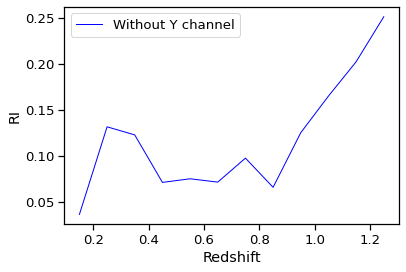

In [ ]:
#plt.plot(z_rel,RI_w, c='coral')
plt.plot(z_rel,RI_wo, c='blue')
plt.ylabel('RI')
plt.xlabel('Redshift')
plt.legend(['Without Y channel'])#'With Y channel',
plt.show()

## Predicted means
---

Create dataframe containing the mean redshift of the predicted PDFs, together with the DES and actual redshifts:

In [ ]:

df_means_pred = res_ts_wo[['Mean']].copy()

df_means_pred = df_means_pred.rename(columns={'Mean': 'z_gammaMDN_woY'})
#df_means_pred['z_gammaMDN_woY'] = res_ts_wo['Mean']
df_means_pred['z_dnf'] = res_ts_wo['ZMEAN_Y4']
df_means_pred['z_spec'] = res_ts_wo['redshift']

df_means_pred.head(5)




,z_gammaMDN_woY,z_dnf,z_spec
0,0.042089,0.055467,0.041100
1,0.035908,0.036285,0.027452
2,0.967223,0.957928,0.909040
3,0.827654,0.852380,0.865400
4,0.433646,0.403977,0.421770


**Figure 11: Mean of the predicted redshifts PDF (orange) and DNF redshifts (blue) vs actual redshift**

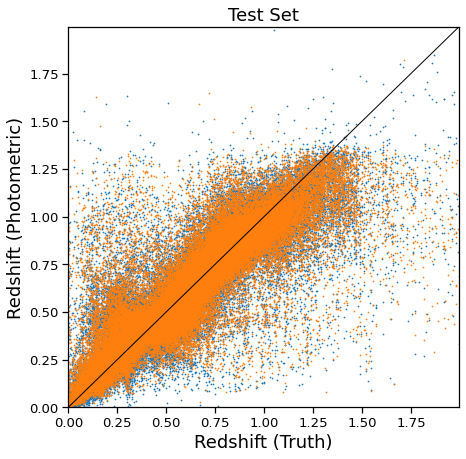

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(df_means_pred.z_spec,df_means_pred.z_dnf,s=0.5)
#ax.scatter(df_means_pred.z_spec,df_means_pred.z_gammaMDN_wY,s=0.5)
ax.scatter(df_means_pred.z_spec,df_means_pred.z_gammaMDN_woY,s=0.5)
ax.plot([0, max(df_means_pred.z_spec)], [0, max(df_means_pred.z_spec)], linewidth=1, color='k')
ax.set_xlim(0, max(df_means_pred.z_spec))
ax.set_ylim(0, max(df_means_pred.z_spec))
ax.set_xlabel('Redshift (Truth)', fontsize=18)
ax.set_ylabel('Redshift (Photometric)', fontsize=18)
ax.set_title('Test Set', fontsize=18)
plt.show()

Save predicted means to .csv file:

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')

#create a csv file
df_means_pred.to_csv("predicted_means_gammaMDN_vs_DNF_vs_actual_My_gammaMDN_withT_1_11Nov2020.csv", index=True, header=True)

Mounted at /content/drive
